# Vehicle routing model for the goods distribution network of a logistics operator in Colombia


Andrés Felipe León Villalba


Catholic University of Colombia, Engineering Faculty, Industrial Engineering Program, Bogotá, D.C., 2020


## VRPTW - Vehicle routing problem with time windows


Rutas con asignación de restricciones.


Solución en 3 fases:
1. Clusterización de toda la base de datos por K-means. 
2. Clusterización de los cluster resultantes de K-means por Optics.
3. Diseño de rutas por cada subcluster resultante de Optics:
    
3.1. Primera solución por ruta con Nearest Neighboor.
3.2. Optimización de cada ruta con local search 2 opt.

In [1]:
# Importar librerías.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec 
from sklearn.neighbors import DistanceMetric
import time
import math
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler 
from sklearn import preprocessing, cluster

# Base de datos

In [3]:
#Importar base de datos.

data = pd.read_csv('205_clients_clustered_con_Si.csv')
print(data)

      ID Client_Depot   Lat_[y]    Lon_[x]  Q_[Kg]  Si_[min]  ai_[min]  \
0      0        Depot  4.640676 -74.104645    0.00         0       360   
1      1    Client 43  4.676398 -74.119865    0.09         4       420   
2      2    Client 45  4.654668 -74.056297  148.59        16       480   
3      3    Client 59  4.690796 -74.045340    0.01        14       480   
4      4    Client 65  4.684040 -74.131382    0.04        16       420   
..   ...          ...       ...        ...     ...       ...       ...   
201  201  Client 2434  4.625745 -74.067527  106.02        14       480   
202  202  Client 2549  4.682609 -74.046543  833.74        19       480   
203  203  Client 2601  4.732527 -74.023632    0.66        17       480   
204  204  Client 2616  4.685686 -74.055888    0.49        11       480   
205  205  Client 2684  4.685688 -74.055889    0.09         7       480   

     bi_[min]    City  
0        1140  Bogota  
1        1080  Bogota  
2         990  Bogota  
3         990  

In [4]:
#Mostrar información de las variables de la base de datos.

#Variables:
#ID: Indice del cliente para el ruteo.
#Lat_[y]: latitud.
#Lon_[x]: longitud.
#Q_[kg]: cantidad de producto a entregar al cliente i.
#Si[min]: tiempo de servicio, el vehículo se demora x tiempo descargando y entregando la mercancía al cliente i.
#ai_[min]: tiempo de inicio de la ventana de tiempo en el cliente i, minuto del día en el que el vehículo puede
          #llegar a entregar la mercancía en el cliente i, es decir el minuto "0" son las 00:00 horas y el 
          #minuto "1439 son las 23:59 horas. 
#bi_[min]: tiempo de finalización de la ventana de tiempo en el cliente i, minuto máximo del día en el que el 
          #vehículo puede salir del cliente i luego de entregarle la mercancía.
    
#**La entrega de los productos puede efectuarse entre el intervalo de tiempo ai_[min] y bi_[min] y debe 
#demorarse Si_[min].

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            206 non-null    int64  
 1   Client_Depot  206 non-null    object 
 2   Lat_[y]       206 non-null    float64
 3   Lon_[x]       206 non-null    float64
 4   Q_[Kg]        206 non-null    float64
 5   Si_[min]      206 non-null    int64  
 6   ai_[min]      206 non-null    int64  
 7   bi_[min]      206 non-null    int64  
 8   City          206 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 14.6+ KB


# Clusterización K-means

In [5]:
#Leer base de datos.
data = pd.read_csv('205_clients_clustered_con_Si.csv')
datanew = data.rename(columns={"Lat_[y]": "Lat", "Lon_[x]": "Lon", "Q_[Kg]": "Q", "Si_[min]": "Si", 
                     "ai_[min]": "ai", "bi_[min]": "bi",})
datanew.head()

,ID,Client_Depot,Lat,Lon,Q,Si,ai,bi,City
0,0,Depot,4.640676,-74.104645,0.00,0,360,1140,Bogota
1,1,Client 43,4.676398,-74.119865,0.09,4,420,1080,Bogota
2,2,Client 45,4.654668,-74.056297,148.59,16,480,990,Bogota
3,3,Client 59,4.690796,-74.045340,0.01,14,480,990,Bogota
4,4,Client 65,4.684040,-74.131382,0.04,16,420,1080,Bogota


In [6]:
print("Total de nodos incluído el depósito:", len (datanew))

Total de nodos incluído el depósito: 206


In [11]:
#Leer base de datos vehiculos.
dataveh = pd.read_excel('Vehiculos.xlsx', sheet_name='vehiculos')
dataveh.head()

,Vehicle,Capacity_[kg]
0,1,5000
1,2,5000
2,3,5000
3,4,5000
4,5,5000


In [12]:
#Mostrar información de las variables de la base de datos de los vehículos.

dataveh.info()
print("Total de vehículos disponibles:", len (dataveh))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Vehicle        5 non-null      int64
 1   Capacity_[kg]  5 non-null      int64
dtypes: int64(2)
memory usage: 208.0 bytes
Total de vehículos disponibles: 5


In [39]:
#Asignación ejes.
datanew.dropna(axis=0, how='any', subset=['Lat','Lon'], inplace=True)

#Asignación variables de latitud y longitud.
X=datanew.loc[:,['Client_Depot','Lat','Lon']]

#Clusterización K-means
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = datanew[['Lat']]
X_axis = datanew[['Lon']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

In [14]:
#Número de clusters.

#Carga total a transportar.
Qtotal = datanew['Q'].sum()
print("Carga total a transportar:", Qtotal)

#Vehiculos requeridos.
Capcarga = dataveh['Capacity_[kg]'].mean()
vehiculosr = math.ceil(Qtotal/Capcarga)
print("Vehiculos requeridos inicialmente (tentativo):", vehiculosr * 2)

#Número de clusters.
Ncluster = math.ceil(vehiculosr/2)
print("Número de clusters K-means inicial:", Ncluster)

Carga total a transportar: 22397.46
Vehiculos requeridos inicialmente (tentativo): 10
Número de clusters K-means inicial: 3


In [15]:
#Predefinir el número de clusters.
km = KMeans(n_clusters=Ncluster)

#Predecir el cluster al que debe ir cada nodo con base en su ubicación.
y_predicted = km.fit_predict(datanew[['Lon', 'Lat']])
y_predicted

array([1, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2,
       2, 2, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2,
       1, 0, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 1,
       2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2,
       0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1,
       0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 0,
       1, 1, 0, 2, 0, 0, 0, 0], dtype=int32)

In [16]:
#Incluir a la base de datos la columna del cluster asignado.
datanew['ClusterK'] = y_predicted
dn = datanew
dn.head()

,ID,Client_Depot,Lat,Lon,Q,Si,ai,bi,City,ClusterK
0,0,Depot,4.640676,-74.104645,0.00,0,360,1140,Bogota,1
1,1,Client 43,4.676398,-74.119865,0.09,4,420,1080,Bogota,1
2,2,Client 45,4.654668,-74.056297,148.59,16,480,990,Bogota,2
3,3,Client 59,4.690796,-74.045340,0.01,14,480,990,Bogota,0
4,4,Client 65,4.684040,-74.131382,0.04,16,420,1080,Bogota,1


In [12]:
#Exportar matriz de distancias.
#dn.to_csv('Asignación de clusters 3C.csv', header=True, index=True)

In [17]:
#Centroides.
km.cluster_centers_

array([[-74.04386577,   4.69187512],
       [-74.12528674,   4.66593086],
       [-74.06100699,   4.64276678]])

Text(0.5, 1.0, 'Clusterización')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


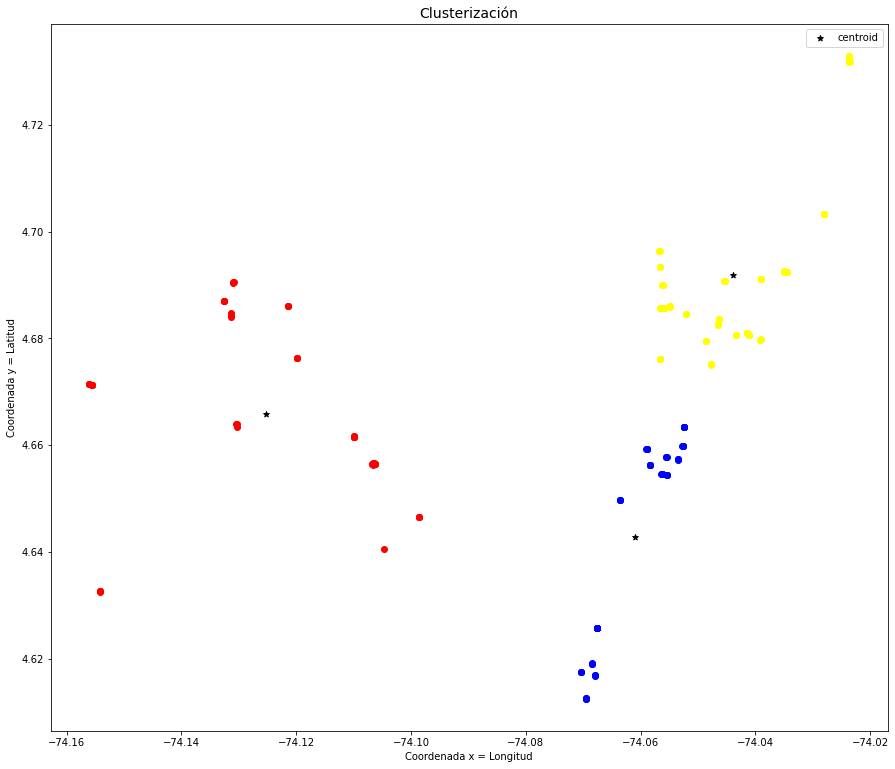

In [18]:
#Gráfica de los clusters.
#***Toca graficar manualmente cada cluster.

plt.rcParams['figure.figsize'] = [15, 13]

data0 = datanew[datanew.ClusterK==0]
data1 = datanew[datanew.ClusterK==1]
data2 = datanew[datanew.ClusterK==2]
data3 = datanew[datanew.ClusterK==3]
data4 = datanew[datanew.ClusterK==4]
data5 = datanew[datanew.ClusterK==5]

plt.scatter(data0.Lon, data0['Lat'],color='yellow')
plt.scatter(data1.Lon, data1['Lat'],color='red')
plt.scatter(data2.Lon, data2['Lat'],color='blue')
plt.scatter(data3.Lon, data3['Lat'],color='green')
plt.scatter(data4.Lon, data4['Lat'],color='gray')
plt.scatter(data5.Lon, data5['Lat'],color='orange')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='black',marker='*',label='centroid')
plt.legend()
plt.xlabel('Coordenada x = Longitud')
plt.ylabel('Coordenada y = Latitud')
plt.title('Clusterización', family='Arial', fontsize=14)

# Cantidad de carga por cluster K-means

In [19]:
#Filtrar base de datos con cluster "n".
data0 = datanew[(datanew['ClusterK'] == 0)]
d0 = data0 #.sort_values(by = 'Q', ascending = False)

data1 = datanew[(datanew['ClusterK'] == 1)]
d1 = data1 #.sort_values(by = 'Q', ascending = False)

data2 = datanew[(datanew['ClusterK'] == 2)]
d2 = data2 #.sort_values(by = 'Q', ascending = False)

data3 = datanew[(datanew['ClusterK'] == 3)]
d3 = data3 #.sort_values(by = 'Q', ascending = False)

data4 = datanew[(datanew['ClusterK'] == 4)]
d4 = data4 #.sort_values(by = 'Q', ascending = False)

data5 = datanew[(datanew['ClusterK'] == 5)]
d5 = data5 #.sort_values(by = 'Q', ascending = False)

data6 = datanew[(datanew['ClusterK'] == 6)]
d6 = data6 #.sort_values(by = 'Q', ascending = False)

data7 = datanew[(datanew['ClusterK'] == 7)]
d7 = data7 #.sort_values(by = 'Q', ascending = False)

In [20]:
#Carga total a transportar en el cluster "n".
Qt0 = data0['Q'].sum()
print("Total carga a transportar cluster 0:", Qt0)

Qt1 = data1['Q'].sum()
print("Total carga a transportar cluster 1:", Qt1)

Qt2 = data2['Q'].sum()
print("Total carga a transportar cluster 2:", Qt2)

Qt3 = data3['Q'].sum()
print("Total carga a transportar cluster 3:", Qt3)

Qt4 = data4['Q'].sum()
print("Total carga a transportar cluster 4:", Qt4)

Qt5 = data5['Q'].sum()
print("Total carga a transportar cluster 5:", Qt5)

Qt6 = data6['Q'].sum()
print("Total carga a transportar cluster 6:", Qt6)

Qt7 = data7['Q'].sum()
print("Total carga a transportar cluster 7:", Qt7)

Total carga a transportar cluster 0: 10636.15
Total carga a transportar cluster 1: 5278.5199999999995
Total carga a transportar cluster 2: 6482.79
Total carga a transportar cluster 3: 0.0
Total carga a transportar cluster 4: 0.0
Total carga a transportar cluster 5: 0.0
Total carga a transportar cluster 6: 0.0
Total carga a transportar cluster 7: 0.0


# Clusterización Optics para cada cluster resultante de K-means, para asignación de carga a vehículos y ventanas de tiempo

# Cluster K-means 0 a Optics

In [21]:
#Filtrar base de datos con cluster "n".
dataC0 = datanew[(datanew['ClusterK'] == 0)]
dataDepot = datanew[(datanew['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, dataC0]
concat0 = pd.concat(concat, sort='False', ignore_index='True')
concat0.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el 
                                                      #cluster incluya el depósito.
data0 = concat0
data0.head()

,City,Client_Depot,ClusterK,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 59,0,3,4.690796,-74.045340,0.01,14,480,990
2,Bogota,Client 67,0,5,4.675178,-74.047681,0.37,17,480,990
3,Bogota,Client 159,0,11,4.692512,-74.034966,323.60,14,480,990
4,Bogota,Client 169,0,12,4.732760,-74.023656,1.16,18,480,990


In [18]:
print("Cantidad de clientes en el cluster:", len(data0))

Cantidad de clientes en el cluster: 66


In [22]:
#Selección y eliminación de columnas irrelevantes en para el analisis 
drop_features = ['Lat','Lon','ClusterK','ID','Client_Depot','City'] 
X = data0.drop(drop_features, axis = 1) 
  
#Filtro de los valores perdidos (si los hay)
X.fillna(method ='ffill', inplace = False) 
  
X.head() 

,Q,Si,ai,bi
0,0.00,0,360,1140
1,0.01,14,480,990
2,0.37,17,480,990
3,323.60,14,480,990
4,1.16,18,480,990


In [23]:
#Escalar los datos para llevar todos los atributos a un nivel comparable
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
#Normalizar los datos para que los datos sigan aproximadamente una distribución gaussiana.
X_normalizada = normalize(X_scaled) 
  
#Conversión de la matriz numpy en un DataFrame de pandas
X_normalizada = pd.DataFrame(X_normalizada) 
  
#Renombre de las columnas
X_normalizada.columns = X.columns 
X_normalizada.head() 

,Q,Si,ai,bi
0,-0.022229,-0.139383,-0.700028,0.700028
1,-0.332481,0.928965,0.115067,-0.115067
2,-0.204912,0.973596,0.071139,-0.071139
3,0.535628,0.831789,0.103030,-0.103030
4,-0.180137,0.979602,0.062969,-0.062969


In [24]:
#Construcción del modelo de clusterización Optics para el cluster "n"
optics_model = OPTICS(min_samples = 11, xi = 0.06, min_cluster_size = 0.08) 
  
#Entrenamiento del modelo
optics_model.fit(X_normalizada) 

OPTICS(min_cluster_size=0.08, min_samples=11, xi=0.06)

In [25]:
#Creando una matriz numpy con números en espacios iguales hasta el rango especificado
space = np.arange(len(X_normalizada)) 
  
#Almacenamiento de la distancia de accesibilidad de cada punto
reachability = optics_model.reachability_[optics_model.ordering_] 
  
#Almacenamiento de las etiquetas de grupo de cada punto
labels = optics_model.labels_[optics_model.ordering_] 
labels

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

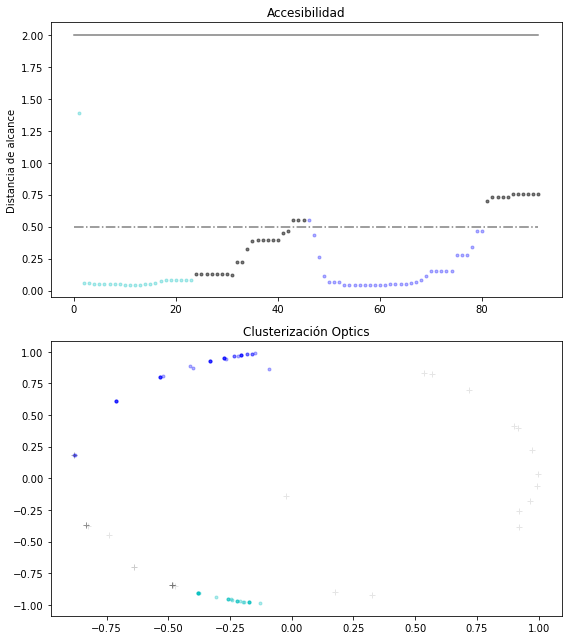

In [26]:
#Parámetros de la gráfica
plt.figure(figsize =(8, 9)) 
G = gridspec.GridSpec(2, 1) 
ax1 = plt.subplot(G[0, :]) 
ax2 = plt.subplot(G[1, 0]) 
  
#Gráfica de accesibilidad-distancia
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = space[labels == Class] 
    Rk = reachability[labels == Class] 
    ax1.plot(Xk, Rk, colour, alpha = 0.3) 
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5) 
ax1.set_ylabel('Distancia de alcance') 
ax1.set_title('Accesibilidad') 
  
#Gráfica Optics clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = X_normalizada[optics_model.labels_ == Class] 
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
      
ax2.plot(X_normalizada.iloc[optics_model.labels_ == -1, 0], 
        X_normalizada.iloc[optics_model.labels_ == -1, 1], 
       'k+', alpha = 0.1) 
ax2.set_title('Clusterización Optics') 

plt.tight_layout() 
plt.show() 

In [27]:
#Incluir a la base de datos la columna del cluster asignado.

X1 = data0 
X1['ClusterO'] = labels
dn = X1
dn.head()

,City,Client_Depot,ClusterK,ID,Lat,Lon,Q,Si,ai,bi,ClusterO
0,Bogota,Depot,1,0,4.640676,-74.104645,0.00,0,360,1140,-1
1,Bogota,Client 59,0,3,4.690796,-74.045340,0.01,14,480,990,0
2,Bogota,Client 67,0,5,4.675178,-74.047681,0.37,17,480,990,0
3,Bogota,Client 159,0,11,4.692512,-74.034966,323.60,14,480,990,0
4,Bogota,Client 169,0,12,4.732760,-74.023656,1.16,18,480,990,0


In [25]:
#Imprimir base de datos con cluster K-means y Optics asignado.
#dn.to_csv('KM 0 a Op.csv', header=True, index=True)

In [28]:
print("Confirmación cantidad de clientes en el cluster:", len(dn))

Confirmación cantidad de clientes en el cluster: 92


In [29]:
#Filtrar base de datos con cluster "n".
data1n = dn[(dn['ClusterO'] == -1)]
d1n = data1n #.sort_values(by = 'Q', ascending = False)

data0 = dn[(dn['ClusterO'] == 0)]
d0 = data0 #.sort_values(by = 'Q', ascending = False)

data1 = dn[(dn['ClusterO'] == 1)]
d1 = data1 #.sort_values(by = 'Q', ascending = False)

data2 = dn[(dn['ClusterO'] == 2)]
d2 = data2 #.sort_values(by = 'Q', ascending = False)

data3 = dn[(dn['ClusterO'] == 3)]
d3 = data3 #.sort_values(by = 'Q', ascending = False)

data4 = dn[(dn['ClusterO'] == 4)]
d4 = data4 #.sort_values(by = 'Q', ascending = False)

data5 = dn[(dn['ClusterO'] == 5)]
d5 = data5 #.sort_values(by = 'Q', ascending = False)

data6 = dn[(dn['ClusterO'] == 6)]
d6 = data6 #.sort_values(by = 'Q', ascending = False)

data7 = dn[(dn['ClusterO'] == 7)]
d7 = data7 #.sort_values(by = 'Q', ascending = False)

In [30]:
#Carga total a transportar en el cluster "n".
Qt1n = data1n['Q'].sum()
print("Total carga a transportar cluster 1n:", Qt1n)

Qt0 = data0['Q'].sum()
print("Total carga a transportar cluster 0:", Qt0)

Qt1 = data1['Q'].sum()
print("Total carga a transportar cluster 1:", Qt1)

Qt2 = data2['Q'].sum()
print("Total carga a transportar cluster 2:", Qt2)

Qt3 = data3['Q'].sum()
print("Total carga a transportar cluster 3:", Qt3)

Qt4 = data4['Q'].sum()
print("Total carga a transportar cluster 4:", Qt4)

Qt5 = data5['Q'].sum()
print("Total carga a transportar cluster 5:", Qt5)

Qt6 = data6['Q'].sum()
print("Total carga a transportar cluster 6:", Qt6)

Qt7 = data7['Q'].sum()
print("Total carga a transportar cluster 7:", Qt7)

Total carga a transportar cluster 1n: 3156.78
Total carga a transportar cluster 0: 4722.57
Total carga a transportar cluster 1: 2756.8
Total carga a transportar cluster 2: 0.0
Total carga a transportar cluster 3: 0.0
Total carga a transportar cluster 4: 0.0
Total carga a transportar cluster 5: 0.0
Total carga a transportar cluster 6: 0.0
Total carga a transportar cluster 7: 0.0


In [31]:
#Cantidad de carga a transportar por ruta.
QR0 = Qt1n
QR1 = Qt0
QR2 = Qt1

In [32]:
datak0 = dn

# Cluster 1 K-means a Optics

In [33]:
#Filtrar base de datos con cluster "n".
dataC1 = datanew[(datanew['ClusterK'] == 1)]
dataDepot = datanew[(datanew['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, dataC1]
concat1 = pd.concat(concat, sort='False', ignore_index='True')
concat1.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el
                                                      #cluster incluya el depósito.
data1 = concat1
data1.head()

,City,Client_Depot,ClusterK,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 43,1,1,4.676398,-74.119865,0.09,4,420,1080
3,Bogota,Client 65,1,4,4.684040,-74.131382,0.04,16,420,1080
4,Bogota,Client 69,1,6,4.686983,-74.132557,0.41,4,420,1080
5,Bogota,Client 250,1,19,4.671351,-74.155489,0.04,10,720,1020


In [34]:
print("Cantidad de clientes en el cluster:", len(data1))

Cantidad de clientes en el cluster: 50


In [35]:
#Selección y eliminación de columnas irrelevantes en para el analisis 
drop_features = ['Lat','Lon','ClusterK','ID','Client_Depot','City'] 
X = data1.drop(drop_features, axis = 1) 
  
#Filtro de los valores perdidos (si los hay)
X.fillna(method ='ffill', inplace = False) 
  
X.head() 

,Q,Si,ai,bi
0,0.00,0,360,1140
2,0.09,4,420,1080
3,0.04,16,420,1080
4,0.41,4,420,1080
5,0.04,10,720,1020


In [36]:
#Escalar los datos para llevar todos los atributos a un nivel comparable
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
#Normalizar los datos para que los datos sigan aproximadamente una distribución gaussiana.
X_normalizada = normalize(X_scaled) 
  
#Conversión de la matriz numpy en un DataFrame de pandas
X_normalizada = pd.DataFrame(X_normalizada) 
  
#Renombre de las columnas
X_normalizada.columns = X.columns 
X_normalizada.head() 

,Q,Si,ai,bi
0,-0.059074,-0.413986,-0.442585,0.793249
1,-0.113738,-0.447858,-0.645854,0.607750
2,-0.105580,0.558379,-0.599244,0.563890
3,-0.113398,-0.447876,-0.645879,0.607774
4,-0.219667,0.148595,0.751258,-0.604382


In [37]:
#Construcción del modelo de clusterización Optics para el cluster "n"
optics_model = OPTICS(min_samples = 11, xi=0.06, min_cluster_size = 0.08) 
  
#Entrenamiento del modelo
optics_model.fit(X_normalizada) 

OPTICS(min_cluster_size=0.08, min_samples=11, xi=0.06)

In [38]:
#Creando una matriz numpy con números en espacios iguales hasta el rango especificado
space = np.arange(len(X_normalizada)) 
  
#Almacenamiento de la distancia de accesibilidad de cada punto
reachability = optics_model.reachability_[optics_model.ordering_] 
  
#Almacenamiento de las etiquetas de grupo de cada punto
labels = optics_model.labels_[optics_model.ordering_] 
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

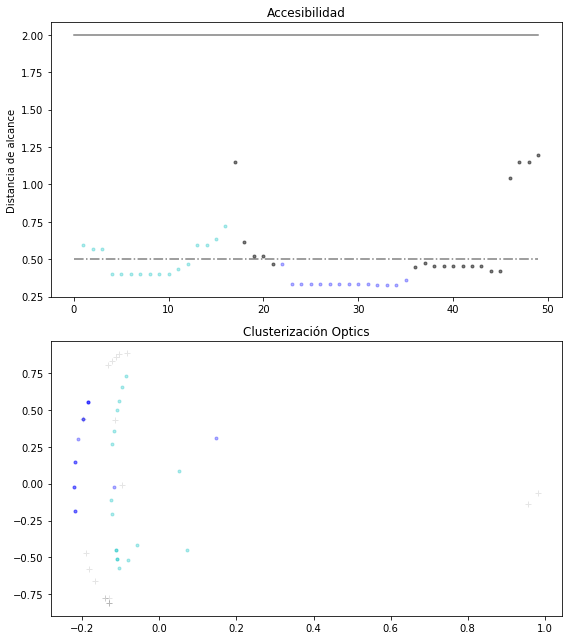

In [37]:
#Parámetros de la gráfica
plt.figure(figsize =(8, 9)) 
G = gridspec.GridSpec(2, 1) 
ax1 = plt.subplot(G[0, :]) 
ax2 = plt.subplot(G[1, 0]) 
  
#Gráfica de accesibilidad-distancia
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = space[labels == Class] 
    Rk = reachability[labels == Class] 
    ax1.plot(Xk, Rk, colour, alpha = 0.3) 
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5) 
ax1.set_ylabel('Distancia de alcance') 
ax1.set_title('Accesibilidad') 
  
#Gráfica Optics clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = X_normalizada[optics_model.labels_ == Class] 
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
      
ax2.plot(X_normalizada.iloc[optics_model.labels_ == -1, 0], 
        X_normalizada.iloc[optics_model.labels_ == -1, 1], 
       'k+', alpha = 0.1) 
ax2.set_title('Clusterización Optics') 

plt.tight_layout() 
plt.show() 

In [38]:
#Incluir a la base de datos la columna del cluster asignado.

X1 = data1 
X1['ClusterO'] = labels
dn = X1
dn.head()

,City,Client_Depot,ClusterK,ID,Lat,Lon,Q,Si,ai,bi,ClusterO
0,Bogota,Depot,1,0,4.640676,-74.104645,0.00,0,360,1140,0
2,Bogota,Client 43,1,1,4.676398,-74.119865,0.09,4,420,1080,0
3,Bogota,Client 65,1,4,4.684040,-74.131382,0.04,16,420,1080,0
4,Bogota,Client 69,1,6,4.686983,-74.132557,0.41,4,420,1080,0
5,Bogota,Client 250,1,19,4.671351,-74.155489,0.04,10,720,1020,0


In [39]:
#Imprimir base de datos con cluster K-means y Optics asignado.
#dn.to_csv('KM 1 a Op.csv', header=True, index=True)

In [40]:
print("Confirmación cantidad de clientes en el cluster:", len(dn))

Confirmación cantidad de clientes en el cluster: 50


In [41]:
#Filtrar base de datos con cluster "n".
data1n = dn[(dn['ClusterO'] == -1)]
d1n = data1n #.sort_values(by = 'Q', ascending = False)

data0 = dn[(dn['ClusterO'] == 0)]
d0 = data0 #.sort_values(by = 'Q', ascending = False)

data1 = dn[(dn['ClusterO'] == 1)]
d1 = data1 #.sort_values(by = 'Q', ascending = False)

data2 = dn[(dn['ClusterO'] == 2)]
d2 = data2 #.sort_values(by = 'Q', ascending = False)

data3 = dn[(dn['ClusterO'] == 3)]
d3 = data3 #.sort_values(by = 'Q', ascending = False)

data4 = dn[(dn['ClusterO'] == 4)]
d4 = data4 #.sort_values(by = 'Q', ascending = False)

data5 = dn[(dn['ClusterO'] == 5)]
d5 = data5 #.sort_values(by = 'Q', ascending = False)

data6 = dn[(dn['ClusterO'] == 6)]
d6 = data6 #.sort_values(by = 'Q', ascending = False)

data7 = dn[(dn['ClusterO'] == 7)]
d7 = data7 #.sort_values(by = 'Q', ascending = False)

In [42]:
#Carga total a transportar en el cluster "n".
Qt1n = data1n['Q'].sum()
print("Total carga a transportar cluster 1n:", Qt1n)

Qt0 = data0['Q'].sum()
print("Total carga a transportar cluster 0:", Qt0)

Qt1 = data1['Q'].sum()
print("Total carga a transportar cluster 1:", Qt1)

Qt2 = data2['Q'].sum()
print("Total carga a transportar cluster 2:", Qt2)

Qt3 = data3['Q'].sum()
print("Total carga a transportar cluster 3:", Qt3)

Qt4 = data4['Q'].sum()
print("Total carga a transportar cluster 4:", Qt4)

Qt5 = data5['Q'].sum()
print("Total carga a transportar cluster 5:", Qt5)

Qt6 = data6['Q'].sum()
print("Total carga a transportar cluster 6:", Qt6)

Qt7 = data7['Q'].sum()
print("Total carga a transportar cluster 7:", Qt7)

Total carga a transportar cluster 1n: 4863.4
Total carga a transportar cluster 0: 263.85
Total carga a transportar cluster 1: 151.26999999999998
Total carga a transportar cluster 2: 0.0
Total carga a transportar cluster 3: 0.0
Total carga a transportar cluster 4: 0.0
Total carga a transportar cluster 5: 0.0
Total carga a transportar cluster 6: 0.0
Total carga a transportar cluster 7: 0.0


In [43]:
#Cantidad de carga a transportar por ruta.
QR3 = Qt1n
QR4 = Qt0
QR5 = Qt1

In [44]:
datak1 = dn

# Cluster 2 K-means a Optics

In [45]:
#Filtrar base de datos con cluster "n".
dataC2 = datanew[(datanew['ClusterK'] == 2)]
dataDepot = datanew[(datanew['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, dataC2]
concat2 = pd.concat(concat, sort='False', ignore_index='True')
concat2.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el
                                                      #cluster incluya el depósito.
data2 = concat2
data2.head()

,City,Client_Depot,ClusterK,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 59,2,3,4.690796,-74.045340,0.01,14,480,990
2,Bogota,Client 67,2,5,4.675178,-74.047681,0.37,17,480,990
3,Bogota,Client 159,2,11,4.692512,-74.034966,323.60,14,480,990
4,Bogota,Client 169,2,12,4.732760,-74.023656,1.16,18,480,990


In [46]:
print("Cantidad de clientes en el cluster:", len(data2))

Cantidad de clientes en el cluster: 92


In [47]:
#Selección y eliminación de columnas irrelevantes en para el analisis 
drop_features = ['Lat','Lon','ClusterK','ID','Client_Depot','City'] 
X = data2.drop(drop_features, axis = 1) 
  
#Filtro de los valores perdidos (si los hay)
X.fillna(method ='ffill', inplace = False) 
  
X.head() 

,Q,Si,ai,bi
0,0.00,0,360,1140
1,0.01,14,480,990
2,0.37,17,480,990
3,323.60,14,480,990
4,1.16,18,480,990


In [48]:
#Escalar los datos para llevar todos los atributos a un nivel comparable
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
#Normalizar los datos para que los datos sigan aproximadamente una distribución gaussiana.
X_normalizada = normalize(X_scaled) 
  
#Conversión de la matriz numpy en un DataFrame de pandas
X_normalizada = pd.DataFrame(X_normalizada) 
  
#Renombre de las columnas
X_normalizada.columns = X.columns 
X_normalizada.head() 

,Q,Si,ai,bi
0,-0.022229,-0.139383,-0.700028,0.700028
1,-0.332481,0.928965,0.115067,-0.115067
2,-0.204912,0.973596,0.071139,-0.071139
3,0.535628,0.831789,0.103030,-0.103030
4,-0.180137,0.979602,0.062969,-0.062969


In [49]:
#Construcción del modelo de clusterización Optics para el cluster "n"
optics_model = OPTICS(min_samples = 11, eps = 0.06, xi = 0.08) 
  
#Entrenamiento del modelo
optics_model.fit(X_normalizada) 

OPTICS(algorithm='auto', cluster_method='xi', eps=0.06, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=11, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.08)

In [50]:
#Creando una matriz numpy con números en espacios iguales hasta el rango especificado
space = np.arange(len(X_normalizada)) 
  
#Almacenamiento de la distancia de accesibilidad de cada punto
reachability = optics_model.reachability_[optics_model.ordering_] 
  
#Almacenamiento de las etiquetas de grupo de cada punto
labels = optics_model.labels_[optics_model.ordering_] 
labels

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

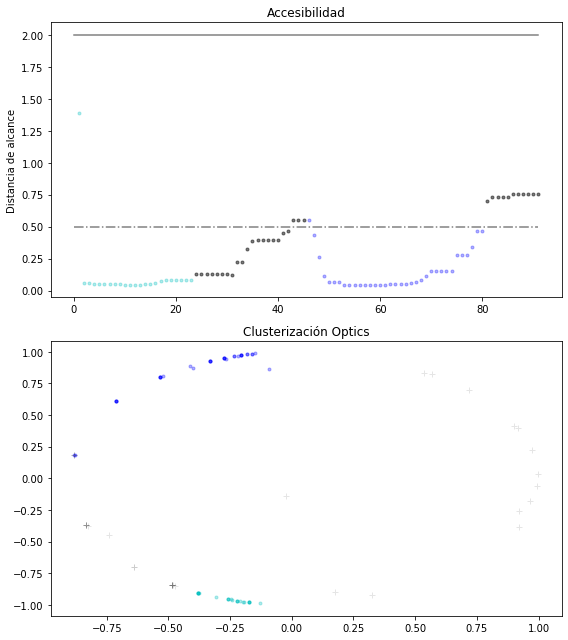

In [51]:
#Parámetros de la gráfica
plt.figure(figsize =(8, 9)) 
G = gridspec.GridSpec(2, 1) 
ax1 = plt.subplot(G[0, :]) 
ax2 = plt.subplot(G[1, 0]) 
  
#Gráfica de accesibilidad-distancia
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = space[labels == Class] 
    Rk = reachability[labels == Class] 
    ax1.plot(Xk, Rk, colour, alpha = 0.3) 
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5) 
ax1.set_ylabel('Distancia de alcance') 
ax1.set_title('Accesibilidad') 
  
#Gráfica Optics clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = X_normalizada[optics_model.labels_ == Class] 
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
      
ax2.plot(X_normalizada.iloc[optics_model.labels_ == -1, 0], 
        X_normalizada.iloc[optics_model.labels_ == -1, 1], 
       'k+', alpha = 0.1) 
ax2.set_title('Clusterización Optics') 

plt.tight_layout() 
plt.show() 

In [52]:
#Incluir a la base de datos la columna del cluster asignado.

X1 = data2 
X1['ClusterO'] = labels
dn = X1
dn.head()

,City,Client_Depot,ClusterK,ID,Lat,Lon,Q,Si,ai,bi,ClusterO
0,Bogota,Depot,1,0,4.640676,-74.104645,0.00,0,360,1140,-1
1,Bogota,Client 59,2,3,4.690796,-74.045340,0.01,14,480,990,0
2,Bogota,Client 67,2,5,4.675178,-74.047681,0.37,17,480,990,0
3,Bogota,Client 159,2,11,4.692512,-74.034966,323.60,14,480,990,0
4,Bogota,Client 169,2,12,4.732760,-74.023656,1.16,18,480,990,0


In [53]:
#Imprimir base de datos con cluster K-means y Optics asignado.
#dn.to_csv('KM 2 a Op.csv', header=True, index=True)

In [54]:
print("Confirmación cantidad de clientes en el cluster:", len(dn))

Confirmación cantidad de clientes en el cluster: 92


In [55]:
#Filtrar base de datos con cluster "n".
data1n = dn[(dn['ClusterO'] == -1)]
d1n = data1n #.sort_values(by = 'Q', ascending = False)

data0 = dn[(dn['ClusterO'] == 0)]
d0 = data0 #.sort_values(by = 'Q', ascending = False)

data1 = dn[(dn['ClusterO'] == 1)]
d1 = data1 #.sort_values(by = 'Q', ascending = False)

data2 = dn[(dn['ClusterO'] == 2)]
d2 = data2 #.sort_values(by = 'Q', ascending = False)

data3 = dn[(dn['ClusterO'] == 3)]
d3 = data3 #.sort_values(by = 'Q', ascending = False)

data4 = dn[(dn['ClusterO'] == 4)]
d4 = data4 #.sort_values(by = 'Q', ascending = False)

data5 = dn[(dn['ClusterO'] == 5)]
d5 = data5 #.sort_values(by = 'Q', ascending = False)

data6 = dn[(dn['ClusterO'] == 6)]
d6 = data6 #.sort_values(by = 'Q', ascending = False)

data7 = dn[(dn['ClusterO'] == 7)]
d7 = data7 #.sort_values(by = 'Q', ascending = False)

In [56]:
#Carga total a transportar en el cluster "n".
Qt1n = data1n['Q'].sum()
print("Total carga a transportar cluster 1n:", Qt1n)

Qt0 = data0['Q'].sum()
print("Total carga a transportar cluster 0:", Qt0)

Qt1 = data1['Q'].sum()
print("Total carga a transportar cluster 1:", Qt1)

Qt2 = data2['Q'].sum()
print("Total carga a transportar cluster 2:", Qt2)

Qt3 = data3['Q'].sum()
print("Total carga a transportar cluster 3:", Qt3)

Qt4 = data4['Q'].sum()
print("Total carga a transportar cluster 4:", Qt4)

Qt5 = data5['Q'].sum()
print("Total carga a transportar cluster 5:", Qt5)

Qt6 = data6['Q'].sum()
print("Total carga a transportar cluster 6:", Qt6)

Qt7 = data7['Q'].sum()
print("Total carga a transportar cluster 7:", Qt7)

Total carga a transportar cluster 1n: 3156.78
Total carga a transportar cluster 0: 4722.57
Total carga a transportar cluster 1: 2756.8
Total carga a transportar cluster 2: 0.0
Total carga a transportar cluster 3: 0.0
Total carga a transportar cluster 4: 0.0
Total carga a transportar cluster 5: 0.0
Total carga a transportar cluster 6: 0.0
Total carga a transportar cluster 7: 0.0


In [57]:
#Cantidad de carga a transportar por ruta.
QR6 = Qt1n
QR7 = Qt0
QR8= Qt1

In [58]:
datak2 = dn

# Matriz de distancias - Fórmula del semiverseno (escalar)

In [59]:
#Conversion de longitud y latitud en radianes para obtener un escalar basado en la formula del 
#semiverseno para el cálculo de la matriz de distancias.

#Conversión de latitud y longitud a radianes
data['Lat_[y]'] = np.radians(data['Lat_[y]'])
data['Lon_[x]'] = np.radians(data['Lon_[x]'])

#Formula del semiverseno, calculo entre dos puntos de una esfera.
dist = DistanceMetric.get_metric('haversine')

#Matriz de latitud y longitud multiplicada por el radio de la tierra en km.
EM = dist.pairwise(data[['Lat_[y]','Lon_[x]']].to_numpy()) * 6371.01 #Radio de la tierra en km.

#Mostrar matriz de distancias.
ExportMatriz = pd.DataFrame(EM, columns=data.Client_Depot.unique(), index=data.Client_Depot.unique())
ExportMatriz

,Depot,Client 43,Client 45,Client 59,Client 65,Client 67,Client 69,Client 75,Client 77,Client 100,...,Client 2281,Client 2282,Client 2294,Client 2368,Client 2398,Client 2434,Client 2549,Client 2601,Client 2616,Client 2684
Depot,0.000000,4.315443,5.579733,8.617287,5.659597,7.387440,6.006866,5.968851,5.419069,4.669788,...,7.320415,7.315994,2.403505,5.727864,7.365296,4.436240,7.950194,13.598528,7.365308,7.365378
Client 43,4.315443,0.000000,7.447913,8.412873,1.533379,8.000935,1.834059,7.661494,7.179808,8.542865,...,7.099179,7.094780,1.975288,1.578419,7.164835,8.085185,8.155165,12.356647,7.165023,7.164945
Client 45,5.579733,7.447913,0.000000,4.196708,8.939429,2.472363,9.183764,0.431951,0.284745,4.175172,...,3.455682,3.453665,5.997001,8.967907,3.449555,3.448558,3.289565,9.383865,3.449336,3.449557
Client 59,8.617287,8.412873,4.196708,0.000000,9.565025,1.755930,9.674950,3.830032,4.101258,8.370548,...,1.358033,1.362653,7.860877,9.557541,1.299825,7.639837,0.920021,5.226841,1.299723,1.299726
Client 65,5.659597,1.533379,8.939429,9.565025,0.000000,9.328337,0.352185,9.135049,8.667247,10.034568,...,8.301201,8.297011,3.441957,0.080852,8.368335,9.596950,9.403564,13.101639,8.368552,8.368446
Client 67,7.387440,8.000935,2.472363,1.755930,9.328337,0.000000,9.497470,2.086692,2.411791,6.644020,...,1.528196,1.529279,7.063925,9.335754,1.481059,5.920388,0.835917,6.911502,1.480747,1.480990
Client 69,6.006866,1.834059,9.183764,9.674950,0.352185,9.497470,0.000000,9.368422,8.909305,10.361236,...,8.430337,8.426227,3.770951,0.279371,8.497726,9.915165,9.544792,13.090338,8.497951,8.497837
Client 75,5.968851,7.661494,0.431951,3.830032,9.135049,2.086692,9.368422,0.000000,0.552870,4.560191,...,3.179857,3.178267,6.281772,9.160275,3.167066,3.841535,2.915035,8.992406,3.166826,3.167057
Client 77,5.419069,7.179808,0.284745,4.101258,8.667247,2.411791,8.909305,0.552870,0.000000,4.278116,...,3.285522,3.283228,5.754324,8.695017,3.284004,3.542699,3.207878,9.311545,3.283801,3.284013
Client 100,4.669788,8.542865,4.175172,8.370548,10.034568,6.644020,10.361236,4.560191,4.278116,0.000000,...,7.524610,7.521865,6.592730,10.091844,7.530534,0.742343,7.464708,13.552590,7.530356,7.530554


In [60]:
#Exportar matriz de distancias.

#ExportMatriz.to_csv('Matriz de distancias KM, Op, NN, LS2opt [Km].csv', header=True, index=True)

# Diseño inicial de rutas por cluster K-means y sub clusters Optics

# Cluster K-means 0, Optics -1

In [61]:
#Filtrar base de datos con cluster "n".
DtF = datak0[(datak0['ClusterO'] == -1)]
dataDepot = datak0[(datak0['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el 
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 45,0,-1,2,4.654668,-74.056297,148.59,16,480,990
3,Bogota,Client 75,0,-1,7,4.657311,-74.053440,599.08,1,480,990
4,Bogota,Client 747,0,-1,67,4.659233,-74.058919,456.97,11,480,990
5,Bogota,Client 790,0,-1,72,4.654407,-74.055449,0.31,20,480,990


In [62]:
len(DF)

9

In [63]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

9

Solución Local search 2 opt, ruta: [0, 5, 7, 8, 1, 4, 2, 6, 3, 0]
---------------------------------------------------------
Distancia total: 16.28358707765963 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 2
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 8, 7, 5, 1, 4, 2, 6, 3, 0]
---------------------------------------------------------
Distancia total: 16.807722587091337 [Km]


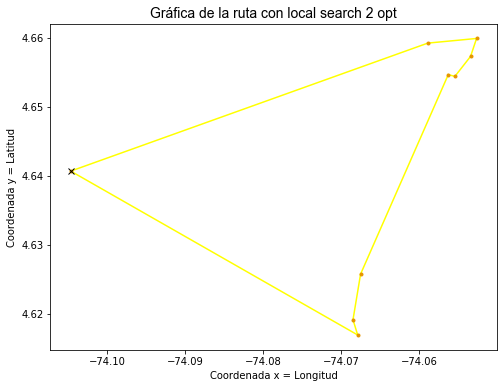

In [64]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos (distancia 
#lineal, no contempla disttribución de calles ni avenidas, p.ej).
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='yellow')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [65]:
#Parámetros gráfica general de rutas
#Ruta 0
x0 = x
y0 = y
sol0 = sol
d0 = d
distancia0 = distancia
tiempo0 = time_final - time_inicio
DF0 = DF

# Cluster K-means 0, Optics 0

In [66]:
#Filtrar base de datos con cluster "n".
DtF = datak0[(datak0['ClusterO'] == 0)]
dataDepot = datak0[(datak0['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 77,0,0,8,4.656253,-74.058314,0.17,19,480,990
2,Bogota,Client 100,0,0,9,4.619136,-74.068475,0.09,14,480,990
3,Bogota,Client 137,0,0,10,4.654689,-74.056256,361.90,4,480,990
4,Bogota,Client 218,0,0,14,4.663432,-74.052403,0.04,14,480,990


In [67]:
len(DF)

28

In [68]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

28

Solución Local search 2 opt, ruta: [0, 6, 11, 14, 13, 26, 2, 25, 24, 23, 18, 20, 21, 16, 19, 15, 17, 22, 5, 3, 12, 27, 7, 4, 10, 9, 1, 8, 0]
---------------------------------------------------------
Distancia total: 17.975947440052575 [Km]
Tiempo: 0.015372514724731445 [seg]
Número de iteraciones: 10
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 19, 15, 17, 22, 20, 21, 18, 16, 23, 24, 25, 2, 26, 6, 11, 13, 14, 5, 3, 12, 1, 8, 9, 27, 7, 4, 10, 0]
---------------------------------------------------------
Distancia total: 19.490168357795394 [Km]


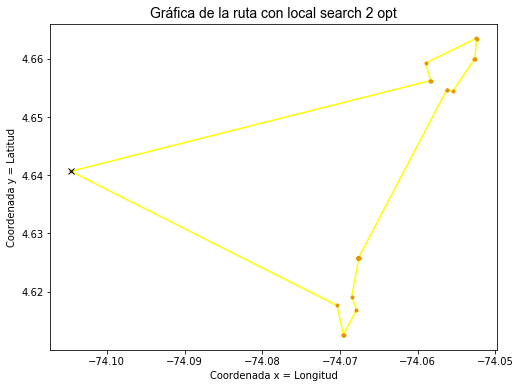

In [69]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='yellow')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [70]:
#Parámetros gráfica general de rutas
#Ruta 1
x1 = x
y1 = y
sol1 = sol
d1 = d
distancia1 = distancia
tiempo1 = time_final - time_inicio
DF1 = DF

# Cluster K-means 0, Optics 1

In [71]:
#Filtrar base de datos con cluster "n".
DtF = datak0[(datak0['ClusterO'] == 1)]
dataDepot = datak0[(datak0['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 793,0,1,73,4.619161,-74.068462,0.04,3,480,990
2,Bogota,Client 887,0,1,78,4.663459,-74.052451,0.04,15,480,990
3,Bogota,Client 953,0,1,82,4.659218,-74.058865,0.23,3,480,990
4,Bogota,Client 1011,0,1,90,4.625750,-74.067653,38.58,10,480,990


In [72]:
len(DF)

31

In [73]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

31

Solución Local search 2 opt, ruta: [0, 17, 16, 24, 8, 1, 4, 22, 23, 9, 19, 6, 13, 5, 7, 18, 11, 30, 26, 28, 10, 15, 27, 20, 21, 29, 2, 25, 12, 3, 14, 0]
---------------------------------------------------------
Distancia total: 18.342447975797974 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 4
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 4, 1, 8, 16, 17, 24, 22, 23, 9, 19, 6, 13, 5, 7, 18, 11, 30, 26, 28, 10, 15, 27, 20, 21, 29, 2, 25, 12, 3, 14, 0]
---------------------------------------------------------
Distancia total: 19.4375252946301 [Km]


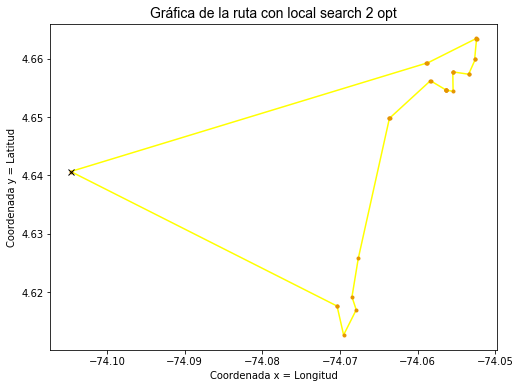

In [74]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='yellow')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [75]:
#Parámetros gráfica general de rutas
#Ruta 2
x2 = x
y2 = y
sol2 = sol
d2 = d
distancia2 = distancia
tiempo2 = time_final - time_inicio
DF2 = DF

# Cluster K-means 1, Optics -1

In [76]:
#Filtrar base de datos con cluster "n".
DtF = datak1[(datak1['ClusterO'] == -1)]
dataDepot = datak1[(datak1['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 938,1,-1,80,4.656388,-74.106656,0.46,1,720,1020
2,Bogota,Client 974,1,-1,88,4.656512,-74.106245,0.07,9,720,1020
3,Bogota,Client 1005,1,-1,89,4.663961,-74.130345,1841.83,6,720,1020
4,Bogota,Client 1184,1,-1,99,4.661615,-74.109927,0.04,12,720,1020


In [77]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

20

Solución Local search 2 opt, ruta: [0, 9, 10, 2, 8, 7, 1, 4, 18, 6, 11, 13, 19, 16, 3, 12, 14, 5, 15, 17, 0]
---------------------------------------------------------
Distancia total: 22.92696133243914 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 4
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 9, 10, 2, 7, 8, 1, 4, 18, 6, 11, 19, 16, 13, 3, 12, 14, 5, 15, 17, 0]
---------------------------------------------------------
Distancia total: 23.170394538282995 [Km]


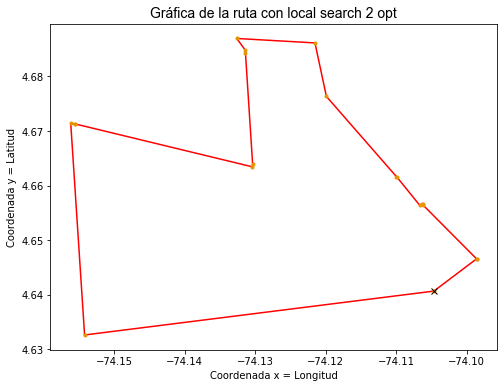

In [78]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='red')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [79]:
#Parámetros gráfica general de rutas
#Ruta 3
x3 = x
y3 = y
sol3 = sol
d3 = d
distancia3 = distancia
tiempo3 = time_final - time_inicio
DF3 = DF

# Cluster K-means 1, Optics 0

In [80]:
#Filtrar base de datos con cluster "n".
DtF = datak1[(datak1['ClusterO'] == 0)]
dataDepot = datak1[(datak1['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el 
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 43,1,0,1,4.676398,-74.119865,0.09,4,420,1080
3,Bogota,Client 65,1,0,4,4.684040,-74.131382,0.04,16,420,1080
4,Bogota,Client 69,1,0,6,4.686983,-74.132557,0.41,4,420,1080
5,Bogota,Client 250,1,0,19,4.671351,-74.155489,0.04,10,720,1020


In [81]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

17

Solución Local search 2 opt, ruta: [0, 6, 10, 7, 14, 8, 1, 13, 15, 16, 3, 2, 9, 11, 4, 12, 5, 0]
---------------------------------------------------------
Distancia total: 22.333216086298208 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 3
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 6, 10, 7, 14, 8, 1, 2, 3, 16, 13, 15, 9, 11, 4, 12, 5, 0]
---------------------------------------------------------
Distancia total: 22.59318811260932 [Km]


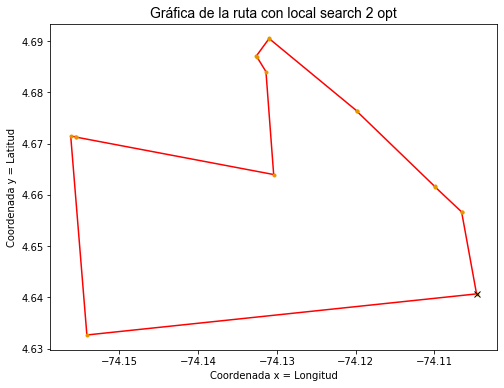

In [82]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='red')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [83]:
#Parámetros gráfica general de rutas
#Ruta 4
x4 = x
y4 = y
sol4 = sol
d4 = d
distancia4 = distancia
tiempo4 = time_final - time_inicio
DF4 = DF

# Cluster K-means 1, Optics 1

In [84]:
#Filtrar base de datos con cluster "n".
DtF = datak1[(datak1['ClusterO'] == 1)]
dataDepot = datak1[(datak1['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el 
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 1219,1,1,103,4.686993,-74.132565,146.80,10,420,1080
2,Bogota,Client 1248,1,1,106,4.656560,-74.106243,0.10,2,720,1020
3,Bogota,Client 1263,1,1,109,4.690477,-74.130893,0.22,13,420,1080
4,Bogota,Client 1307,1,1,115,4.632621,-74.154167,0.02,8,720,1020


In [85]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

15

Solución Local search 2 opt, ruta: [0, 9, 2, 13, 6, 7, 12, 8, 11, 14, 3, 1, 10, 5, 4, 0]
---------------------------------------------------------
Distancia total: 20.7072633724402 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 1
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 9, 2, 13, 6, 7, 12, 8, 11, 14, 3, 1, 10, 5, 4, 0]
---------------------------------------------------------
Distancia total: 20.7072633724402 [Km]


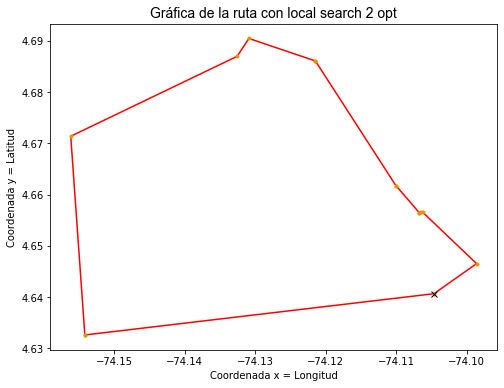

In [86]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='red')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [87]:
#Parámetros gráfica general de rutas
#Ruta 5
x5 = x
y5 = y
sol5 = sol
d5 = d
distancia5 = distancia
tiempo5 = time_final - time_inicio
DF5 = DF

# Cluster K-means 2, Optics -1

In [88]:
#Filtrar base de datos con cluster "n".
DtF = datak2[(datak2['ClusterO'] == -1)]
dataDepot = datak2[(datak2['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 745,2,-1,66,4.676217,-74.056576,0.49,19,480,990
3,Bogota,Client 765,2,-1,68,4.692590,-74.034995,0.01,7,480,990
4,Bogota,Client 770,2,-1,69,4.685743,-74.056007,45.17,13,480,990
5,Bogota,Client 775,2,-1,71,4.703226,-74.027982,0.04,17,480,990


In [89]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

34

Solución Local search 2 opt, ruta: [0, 19, 6, 1, 23, 30, 7, 10, 11, 12, 25, 18, 21, 15, 20, 17, 16, 2, 26, 4, 13, 31, 14, 22, 8, 5, 24, 9, 32, 33, 29, 3, 27, 28, 0]
---------------------------------------------------------
Distancia total: 30.718795342435982 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 5
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 19, 6, 1, 23, 30, 7, 10, 11, 12, 25, 18, 21, 15, 20, 17, 16, 2, 26, 14, 24, 9, 32, 33, 29, 3, 27, 28, 5, 22, 8, 4, 13, 31, 0]
---------------------------------------------------------
Distancia total: 34.44442073127705 [Km]


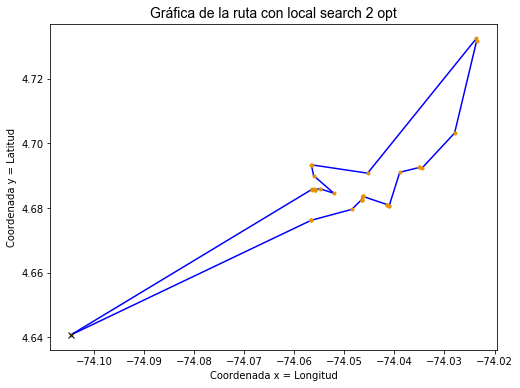

In [90]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='blue')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [91]:
#Parámetros gráfica general de rutas
#Ruta 6
x6 = x
y6 = y
sol6 = sol
d6 = d
distancia6 = distancia
tiempo6 = time_final - time_inicio
DF6 = DF

# Cluster K-means 2, Optics 0

In [92]:
#Filtrar base de datos con cluster "n".
DtF = datak2[(datak2['ClusterO'] == 0)]
dataDepot = datak2[(datak2['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el 
                                                      #cluster incluya el depósito.
DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 59,2,0,3,4.690796,-74.045340,0.01,14,480,990
2,Bogota,Client 67,2,0,5,4.675178,-74.047681,0.37,17,480,990
3,Bogota,Client 159,2,0,11,4.692512,-74.034966,323.60,14,480,990
4,Bogota,Client 169,2,0,12,4.732760,-74.023656,1.16,18,480,990


In [93]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

24

Solución Local search 2 opt, ruta: [0, 10, 6, 2, 5, 16, 17, 7, 19, 12, 13, 3, 15, 9, 21, 18, 23, 4, 11, 1, 22, 8, 20, 14, 0]
---------------------------------------------------------
Distancia total: 30.27912606537152 [Km]
Tiempo: 0.0 [seg]
Número de iteraciones: 5
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 10, 6, 2, 5, 16, 17, 7, 19, 12, 13, 3, 15, 1, 22, 11, 8, 20, 14, 9, 21, 18, 23, 4, 0]
---------------------------------------------------------
Distancia total: 33.61054749800586 [Km]


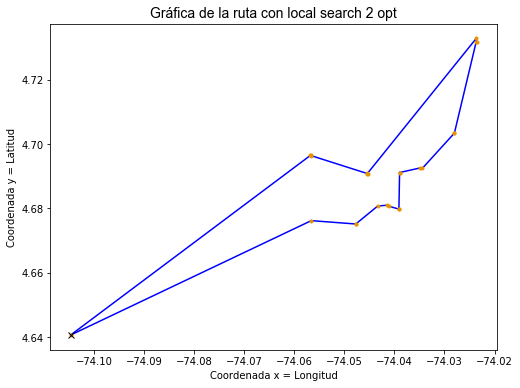

In [94]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='blue')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [95]:
#Parámetros gráfica general de rutas
#Ruta 7
x7 = x
y7 = y
sol7 = sol
d7 = d
distancia7 = distancia
tiempo7 = time_final - time_inicio
DF7 = DF

# Cluster K-means 2, Optics 1

In [96]:
#Filtrar base de datos con cluster "n".
DtF = datak2[(datak2['ClusterO'] == 1)]
dataDepot = datak2[(datak2['Client_Depot'] == 'Depot')]

#Unir base de datos de los clusters y el depósito.
concat = [dataDepot, DtF]
concatt = pd.concat(concat, sort='False', ignore_index='True')
concatt.drop_duplicates('Client_Depot', inplace=True) #Eliminar duplicado del depot en caso de que el 
                                                      #cluster incluya el depósito.

DF = concatt
DF.head()

,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 1306,2,1,114,4.684599,-74.052093,0.09,4,480,990
2,Bogota,Client 1321,2,1,118,4.680718,-74.043312,0.04,10,480,990
3,Bogota,Client 1327,2,1,119,4.685740,-74.055960,0.01,3,480,990
4,Bogota,Client 1332,2,1,121,4.680724,-74.043347,0.16,6,480,990


In [97]:
#Extraer cantidad de nodos.
Client_Depot = DF.loc[:, 'Client_Depot']
IDMatriz = np.array(Client_Depot)
nodos = IDMatriz

#Cantidad de nodos.
nodos = len(nodos)
nodos

36

Solución Local search 2 opt, ruta: [0, 13, 8, 7, 1, 26, 33, 3, 28, 6, 12, 18, 23, 10, 11, 32, 29, 30, 31, 17, 24, 35, 9, 22, 15, 14, 16, 19, 34, 25, 5, 2, 4, 21, 20, 27, 0]
---------------------------------------------------------
Distancia total: 30.337397041591274 [Km]
Tiempo: 0.015319585800170898 [seg]
Número de iteraciones: 7
---------------------------------------------------------
Comparación resultados Nearest neightbot vs Local search 2 opt
---------------------------------------------------------
Solución Nearest Neighbor, ruta: [0, 13, 8, 20, 21, 27, 4, 2, 25, 5, 34, 19, 16, 14, 15, 22, 9, 35, 24, 17, 31, 30, 29, 32, 11, 10, 23, 26, 33, 3, 28, 6, 12, 18, 7, 1, 0]
---------------------------------------------------------
Distancia total: 30.840248057622354 [Km]


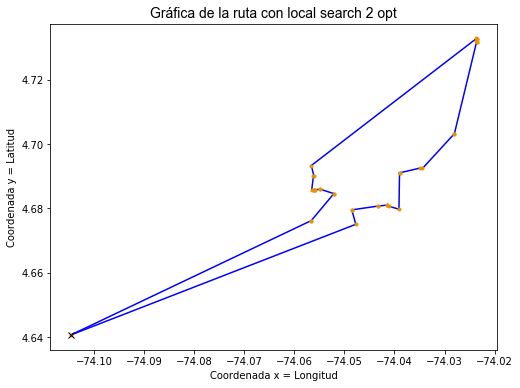

In [98]:
#Creación de la red de datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = DF.loc[:, 'Lon']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = DF.loc[:, 'Lat']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Matriz de distancia en un diccionario.
#Se obtiene un escalar a partir de la matriz de distancias con la función del semiverseno, con ello 
#se obtiene un cálculo de distancia del 98.9% cercano a la distancia real entre nodos.
distancia = {(i,j):np.hypot(x[i]-x[j], y[i]-y[j])*111.138746329478 for i,j in arcos}

#Función Nearest Neighbor.
def Nearest_neighbor(starting_node, clientes, distancia):
    NN = [starting_node]
    n = len(clientes)
    
    while len(NN) < n:
        k = NN[-1]
        nn = {(k,j): distancia[(k,j)] for j in clientes if j!=k and j not in NN}
        nn.items()
        new = min(nn.items(), key = lambda x: x[1])
        NN.append(new[0][1])
    
    NN.append(starting_node)
    
    return NN

#Calculo de la distancia total de la ruta.
def total_distancia(lista, distancia):
    
    dist = 0
    for n in range(len(lista)-1):
        i = lista[n]
        j = lista[n+1]
        dist = dist + distancia[(i,j)]
    
    return dist

#Solución inicial con Nearest Neighbor.
#Para iniciar una solución con local search 2 opt, se necesita de una solución previa.
starting_node = 0
NN = Nearest_neighbor(starting_node, clientes, distancia)

#Distancia total de la solución Nearest Neighbor.
d = total_distancia(NN, distancia)

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Implementación Local search 2-opt.
#Parte 1, buscar la mejor combinación.
def LS_2opt(NN, distancia):
    
    min_change = 0
    
    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            change = costo_nuevo - costo_actual
            
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
                
    if min_change < 0:
        NN[min_i+1: min_j+1] = NN[min_i+1: min_j+1][::-1]
        
    return NN

#Parte 2, hace los cambios, eliminar cruces.
time_inicio = time.time()
sol = NN.copy()

cambio = 1
count = 0

while cambio != 0:
    count = count + 1
    inicial = total_distancia(sol, distancia)
    sol = LS_2opt(sol, distancia).copy()
    final = total_distancia(sol, distancia)
    
    cambio = np.abs(final - inicial)
    
time_final = time.time()

print("Solución Local search 2 opt, ruta:", sol)
print("---------------------------------------------------------")
print("Distancia total:", total_distancia(sol, distancia), "[Km]")
print("Tiempo:", time_final - time_inicio, "[seg]")
print("Número de iteraciones:", count)

print("---------------------------------------------------------")
print("Comparación resultados Nearest neightbot vs Local search 2 opt")
print("---------------------------------------------------------")
print("Solución Nearest Neighbor, ruta:", NN)
print("---------------------------------------------------------")
print("Distancia total:", d, "[Km]")

#Gráfica de la solución local search.
plt.rcParams['figure.figsize'] = [8, 6]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')
    
#Graficar ruta de local search.
for n in range(len(sol)-1):
    plt.plot([x[sol[n]], x[sol[n+1]]], [y[sol[n]], y[sol[n+1]]], color='blue')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Gráfica de la ruta con local search 2 opt', family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

In [99]:
#Parámetros gráfica general de rutas
#Ruta 8
x8 = x
y8 = y
sol8 = sol
d8 = d
distancia8 = distancia
tiempo8 = time_final - time_inicio
DF8 = DF

# Gráfica de la red de rutas

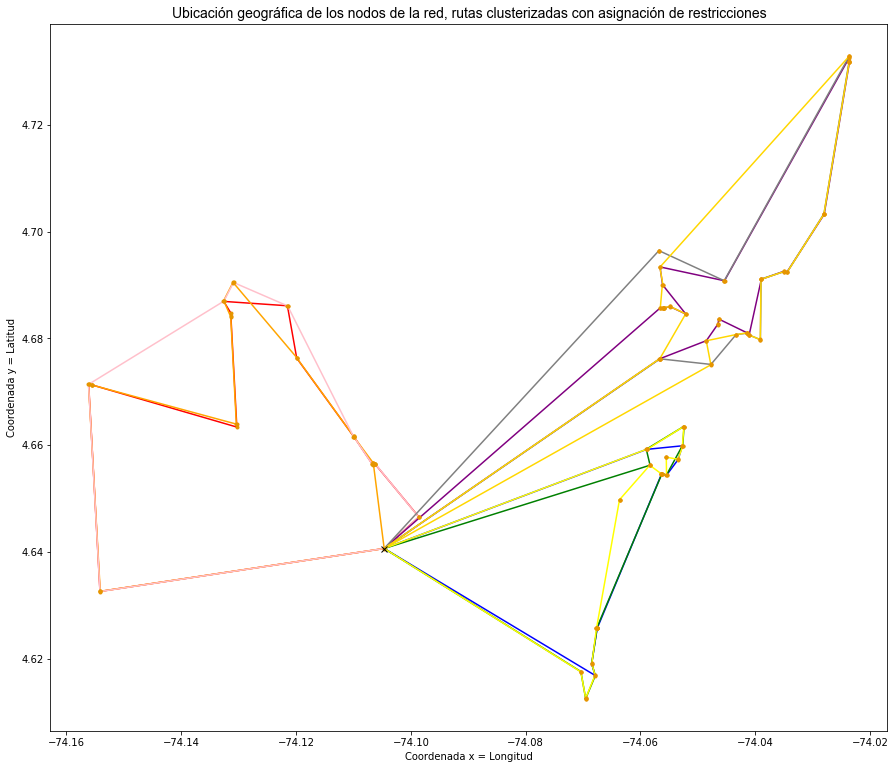

In [100]:
#Importar base de datos.
data = pd.read_csv('205_clients_clustered_con_Si.csv')

#Extraer lista de nodos.
nodolist = pd.read_csv('205_clients_clustered_con_Si.csv', usecols=['ID','Client_Depot'])

#Cantidad de nodos.
nodos = len(nodolist)

#Creación de gráfica y datos.
n = nodos
clientes = [i for i in range(n)]
arcos = [(i,j) for i in range (n) for j in range (n) if i!=j]

#Extraer columna de longitud.
Longitud = data.loc[:, 'Lon_[x]']
Lonmatriz = np.array(Longitud)
x = Lonmatriz

#Extraer columna de latitud.
Latitud = data.loc[:, 'Lat_[y]']
Latmatriz = np.array(Latitud)
y = Latmatriz

#Creación de coordenadas.
x = Lonmatriz
y = Latmatriz

#Extraer depósito.
depotmatriz = np.column_stack((Lonmatriz, Latmatriz))
depot = depotmatriz[:1]

#Latitud y longitud del depósito.
depotlon = depot[:,0]
depotlat = depot[:,1]

#Grafica de los nodos.
plt.rcParams['figure.figsize'] = [15, 13]

#Nombre de los nodos.
#for n in range(len(x)):
 #   plt.annotate(str(n), xy=(x[n], y[n]), xytext=(x[n], y[n]), color='black')

#Ruta 0
for n in range(len(sol0)-1):
    plt.plot([x0[sol0[n]], x0[sol0[n+1]]], [y0[sol0[n]], y0[sol0[n+1]]], color='blue')

#Ruta 1
for n in range(len(sol1)-1):
    plt.plot([x1[sol1[n]], x1[sol1[n+1]]], [y1[sol1[n]], y1[sol1[n+1]]], color='green')

#Ruta 2
for n in range(len(sol2)-1):
    plt.plot([x2[sol2[n]], x2[sol2[n+1]]], [y2[sol2[n]], y2[sol2[n+1]]], color='yellow')

#Ruta 3
for n in range(len(sol3)-1):
    plt.plot([x3[sol3[n]], x3[sol3[n+1]]], [y3[sol3[n]], y3[sol3[n+1]]], color='red')
    
#Ruta 4
for n in range(len(sol4)-1):
    plt.plot([x4[sol4[n]], x4[sol4[n+1]]], [y4[sol4[n]], y4[sol4[n+1]]], color='orange')
     
#Ruta 5
for n in range(len(sol5)-1):
    plt.plot([x5[sol5[n]], x5[sol5[n+1]]], [y5[sol5[n]], y5[sol5[n+1]]], color='pink')
  
#Ruta 6
for n in range(len(sol6)-1):
    plt.plot([x6[sol6[n]], x6[sol6[n+1]]], [y6[sol6[n]], y6[sol6[n+1]]], color='purple')

#Ruta 7
for n in range(len(sol7)-1):
    plt.plot([x7[sol7[n]], x7[sol7[n+1]]], [y7[sol7[n]], y7[sol7[n+1]]], color='grey')
    
#Ruta 8
for n in range(len(sol8)-1):
    plt.plot([x8[sol8[n]], x8[sol8[n+1]]], [y8[sol8[n]], y8[sol8[n+1]]], color='gold')

mapa = plt.plot(x, y, marker='.', linewidth=0, color='#e69500')
mapa = plt.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
mapa = plt.title('Ubicación geográfica de los nodos de la red, rutas clusterizadas con asignación de restricciones',
                 family='Arial', fontsize=14)
mapa = plt.xlabel('Coordenada x = Longitud')
mapa = plt.ylabel('Coordenada y = Latitud')

mapa = plt.show()

#Clientes == puntos.
#Depósito == x.

Text(0.5, 1.0, 'Ruta 8')

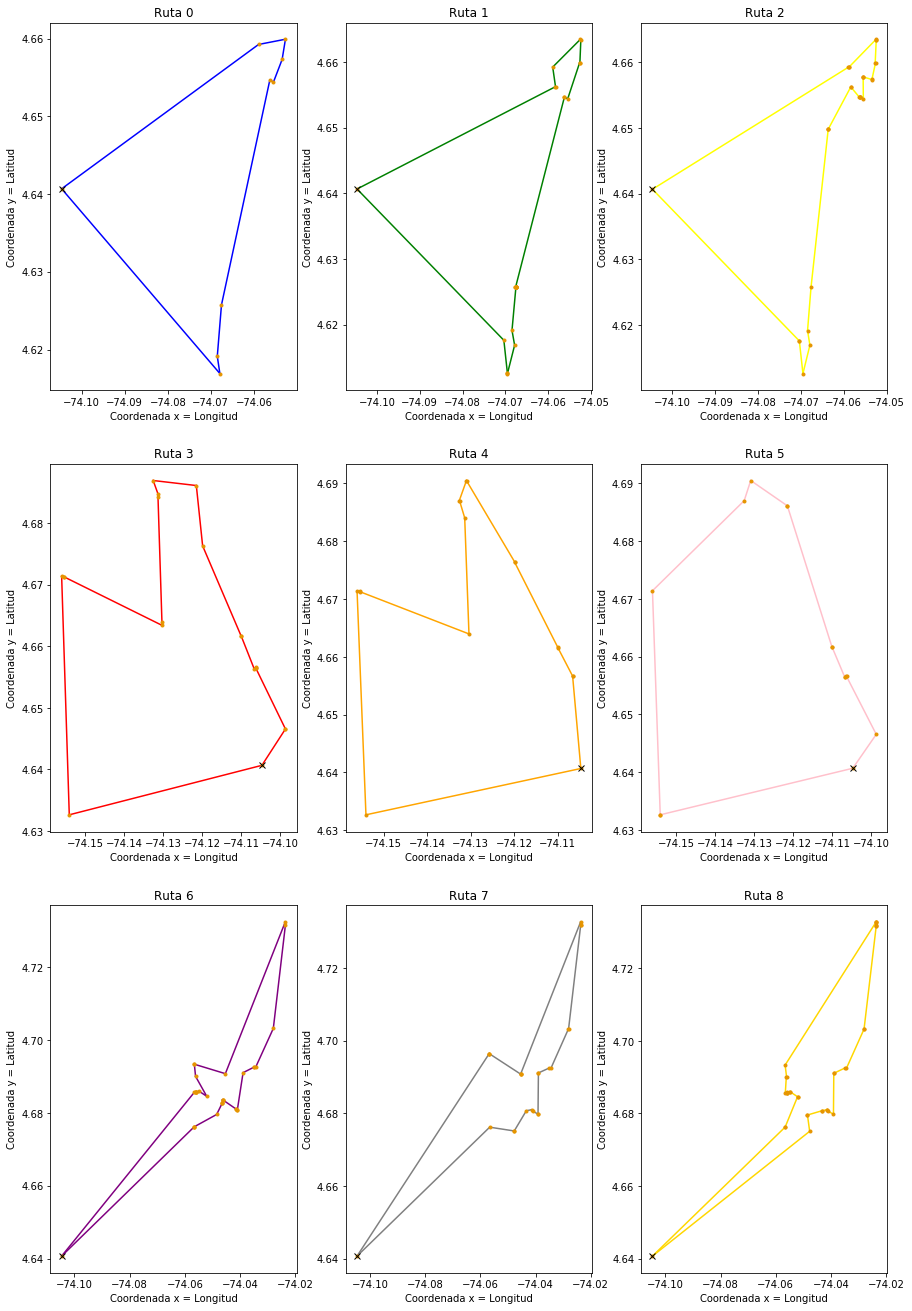

In [101]:
#Gráfica de rutas individuales

plt.figure(figsize =(15, 23)) 
G = gridspec.GridSpec(3, 3) 
ax0 = plt.subplot(G[0, 0]) 
ax1 = plt.subplot(G[0, 1])
ax2 = plt.subplot(G[0, 2])
ax3 = plt.subplot(G[1, 0])
ax4 = plt.subplot(G[1, 1])
ax5 = plt.subplot(G[1, 2])
ax6 = plt.subplot(G[2, 0])
ax7 = plt.subplot(G[2, 1])
ax8 = plt.subplot(G[2, 2])

#Ruta 0
for n in range(len(sol0)-1):
    ax0.plot([x0[sol0[n]], x0[sol0[n+1]]], [y0[sol0[n]], y0[sol0[n+1]]], color='blue')

ax0.plot(x0, y0, marker='.', linewidth=0, color='#e69500')
ax0.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax0.set_xlabel('Coordenada x = Longitud')
ax0.set_ylabel('Coordenada y = Latitud')
ax0.set_title('Ruta 0')

#Ruta 1
for n in range(len(sol1)-1):
    ax1.plot([x1[sol1[n]], x1[sol1[n+1]]], [y1[sol1[n]], y1[sol1[n+1]]], color='green')

ax1.plot(x1, y1, marker='.', linewidth=0, color='#e69500')
ax1.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax1.set_xlabel('Coordenada x = Longitud')
ax1.set_ylabel('Coordenada y = Latitud')
ax1.set_title('Ruta 1')

#Ruta 2
for n in range(len(sol2)-1):
    ax2.plot([x2[sol2[n]], x2[sol2[n+1]]], [y2[sol2[n]], y2[sol2[n+1]]], color='yellow')

ax2.plot(x2, y2, marker='.', linewidth=0, color='#e69500')
ax2.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax2.set_xlabel('Coordenada x = Longitud')
ax2.set_ylabel('Coordenada y = Latitud')
ax2.set_title('Ruta 2')

#Ruta 3
for n in range(len(sol3)-1):
    ax3.plot([x3[sol3[n]], x3[sol3[n+1]]], [y3[sol3[n]], y3[sol3[n+1]]], color='red')

ax3.plot(x3, y3, marker='.', linewidth=0, color='#e69500')
ax3.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax3.set_xlabel('Coordenada x = Longitud')
ax3.set_ylabel('Coordenada y = Latitud')
ax3.set_title('Ruta 3')

#Ruta 4
for n in range(len(sol4)-1):
    ax4.plot([x4[sol4[n]], x4[sol4[n+1]]], [y4[sol4[n]], y4[sol4[n+1]]], color='orange')

ax4.plot(x4, y4, marker='.', linewidth=0, color='#e69500')
ax4.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax4.set_xlabel('Coordenada x = Longitud')
ax4.set_ylabel('Coordenada y = Latitud')
ax4.set_title('Ruta 4')

#Ruta 5
for n in range(len(sol5)-1):
    ax5.plot([x5[sol5[n]], x5[sol5[n+1]]], [y5[sol5[n]], y5[sol5[n+1]]], color='pink')

ax5.plot(x5, y5, marker='.', linewidth=0, color='#e69500')
ax5.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax5.set_xlabel('Coordenada x = Longitud')
ax5.set_ylabel('Coordenada y = Latitud')
ax5.set_title('Ruta 5')

#Ruta 6
for n in range(len(sol6)-1):
    ax6.plot([x6[sol6[n]], x6[sol6[n+1]]], [y6[sol6[n]], y6[sol6[n+1]]], color='purple')

ax6.plot(x6, y6, marker='.', linewidth=0, color='#e69500')
ax6.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax6.set_xlabel('Coordenada x = Longitud')
ax6.set_ylabel('Coordenada y = Latitud')
ax6.set_title('Ruta 6')

#Ruta 7
for n in range(len(sol7)-1):
    ax7.plot([x7[sol7[n]], x7[sol7[n+1]]], [y7[sol7[n]], y7[sol7[n+1]]], color='grey')

ax7.plot(x7, y7, marker='.', linewidth=0, color='#e69500')
ax7.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax7.set_xlabel('Coordenada x = Longitud')
ax7.set_ylabel('Coordenada y = Latitud')
ax7.set_title('Ruta 7')

#Ruta 8
for n in range(len(sol8)-1):
    ax8.plot([x8[sol8[n]], x8[sol8[n+1]]], [y8[sol8[n]], y8[sol8[n+1]]], color='gold')

ax8.plot(x8, y8, marker='.', linewidth=0, color='#e69500')
ax8.plot(depotlon, depotlat, marker='x', linewidth=0, color='black')
ax8.set_xlabel('Coordenada x = Longitud')
ax8.set_ylabel('Coordenada y = Latitud')
ax8.set_title('Ruta 8')

In [102]:
#Resultados de distancia

print("Distancia total Nearest Neighboor:", d0+d1+d2+d3+d4+d5+d6+d7+d8, "[Km]")
print("Distancia total Local Search 2 opt:", total_distancia(sol0, distancia0)+
      total_distancia(sol1, distancia1)+total_distancia(sol2, distancia2)+total_distancia(sol3, distancia3)
      +total_distancia(sol4, distancia4)+total_distancia(sol5, distancia5)+total_distancia(sol6, distancia6)
      +total_distancia(sol7, distancia7)+total_distancia(sol8, distancia8), "[Km]")
print("Tiempo total de solución Local Search 2 opt:", tiempo0+tiempo1+tiempo2+tiempo3+tiempo4+tiempo5
     +tiempo6+tiempo7+tiempo8, "[seg]")

Distancia total Nearest Neighboor: 221.1014785497546 [Km]
Distancia total Local Search 2 opt: 209.90474173408649 [Km]
Tiempo total de solución Local Search 2 opt: 0.030692100524902344 [seg]


# Evaluación restricciones

In [103]:
#Rutas
print("Rutas")
print("Ruta 0:", sol0, "Cantidad de clientes por ruta:", len(sol0)-2+1)
print("Ruta 1:", sol1, "Cantidad de clientes por ruta:", len(sol1)-2)
print("Ruta 2:", sol2, "Cantidad de clientes por ruta:", len(sol2)-2)
print("Ruta 3:", sol3, "Cantidad de clientes por ruta:", len(sol3)-2)
print("Ruta 4:", sol4, "Cantidad de clientes por ruta:", len(sol4)-2)
print("Ruta 5:", sol5, "Cantidad de clientes por ruta:", len(sol5)-2)
print("Ruta 6:", sol6, "Cantidad de clientes por ruta:", len(sol6)-2)
print("Ruta 7:", sol7, "Cantidad de clientes por ruta:", len(sol7)-2)
print("Ruta 8:", sol8, "Cantidad de clientes por ruta:", len(sol8)-2)
print("Total de clientes:", len(sol0+sol1+sol2+sol3+sol4+sol5+sol6+sol7+sol8)-(2*9))
print("\n", "-------------------------------------------------------------------------------")

print("Cantidad de carga a transportar en la ruta 0:", QR0, "[kg]")
print("Cantidad de carga a transportar en la ruta 1:", QR1, "[kg]")
print("Cantidad de carga a transportar en la ruta 2:", QR2, "[kg]")
print("Cantidad de carga a transportar en la ruta 3:", QR3, "[kg]")
print("Cantidad de carga a transportar en la ruta 4:", QR4, "[kg]")
print("Cantidad de carga a transportar en la ruta 5:", QR5, "[kg]")
print("Cantidad de carga a transportar en la ruta 6:", QR6, "[kg]")
print("Cantidad de carga a transportar en la ruta 7:", QR7, "[kg]")
print("Cantidad de carga a transportar en la ruta 8:", QR8, "[kg]")

Qtotalrutas = QR0+QR1+QR2+QR3+QR4+QR5+QR6+QR7+QR8
print("Total carga a transportar:", Qtotalrutas, "[kg]")

Rutas
Ruta 0: [0, 5, 7, 8, 1, 4, 2, 6, 3, 0] Cantidad de clientes por ruta: 9
Ruta 1: [0, 6, 11, 14, 13, 26, 2, 25, 24, 23, 18, 20, 21, 16, 19, 15, 17, 22, 5, 3, 12, 27, 7, 4, 10, 9, 1, 8, 0] Cantidad de clientes por ruta: 27
Ruta 2: [0, 17, 16, 24, 8, 1, 4, 22, 23, 9, 19, 6, 13, 5, 7, 18, 11, 30, 26, 28, 10, 15, 27, 20, 21, 29, 2, 25, 12, 3, 14, 0] Cantidad de clientes por ruta: 30
Ruta 3: [0, 9, 10, 2, 8, 7, 1, 4, 18, 6, 11, 13, 19, 16, 3, 12, 14, 5, 15, 17, 0] Cantidad de clientes por ruta: 19
Ruta 4: [0, 6, 10, 7, 14, 8, 1, 13, 15, 16, 3, 2, 9, 11, 4, 12, 5, 0] Cantidad de clientes por ruta: 16
Ruta 5: [0, 9, 2, 13, 6, 7, 12, 8, 11, 14, 3, 1, 10, 5, 4, 0] Cantidad de clientes por ruta: 14
Ruta 6: [0, 19, 6, 1, 23, 30, 7, 10, 11, 12, 25, 18, 21, 15, 20, 17, 16, 2, 26, 4, 13, 31, 14, 22, 8, 5, 24, 9, 32, 33, 29, 3, 27, 28, 0] Cantidad de clientes por ruta: 33
Ruta 7: [0, 10, 6, 2, 5, 16, 17, 7, 19, 12, 13, 3, 15, 9, 21, 18, 23, 4, 11, 1, 22, 8, 20, 14, 0] Cantidad de clientes por rut

# Matriz de tiempos

In [104]:
#Conversion de longitud y latitud en radianes para obtener la matriz de distancia con la formula del
#semiverseno, la cual es dividida por una velocidad promedio de 30Km/h, multiplicado por 60 min.

#Leer base de datos
data = pd.read_csv('205_clients_clustered_con_Si.csv')

#Conversión de latitud y longitud a radianes
data['Lat_[y]'] = np.radians(data['Lat_[y]'])
data['Lon_[x]'] = np.radians(data['Lon_[x]'])

#Formula del semiverseno, calculo entre dos puntos de una esfera.
dist = DistanceMetric.get_metric('haversine')

#Matriz de latitud y longitud multiplicada por el radio de la tierra en km.
EM = dist.pairwise(data[['Lat_[y]','Lon_[x]']].to_numpy()) * 6371.01 #Radio de la tierra en km.
#EM = (EM1/30)*60

#Mostrar matriz de distancias.
ExportMatriz = pd.DataFrame(EM, columns=data.Client_Depot.unique(), index=data.Client_Depot.unique())
ExportMatriz

,Depot,Client 43,Client 45,Client 59,Client 65,Client 67,Client 69,Client 75,Client 77,Client 100,...,Client 2281,Client 2282,Client 2294,Client 2368,Client 2398,Client 2434,Client 2549,Client 2601,Client 2616,Client 2684
Depot,0.000000,4.315443,5.579733,8.617287,5.659597,7.387440,6.006866,5.968851,5.419069,4.669788,...,7.320415,7.315994,2.403505,5.727864,7.365296,4.436240,7.950194,13.598528,7.365308,7.365378
Client 43,4.315443,0.000000,7.447913,8.412873,1.533379,8.000935,1.834059,7.661494,7.179808,8.542865,...,7.099179,7.094780,1.975288,1.578419,7.164835,8.085185,8.155165,12.356647,7.165023,7.164945
Client 45,5.579733,7.447913,0.000000,4.196708,8.939429,2.472363,9.183764,0.431951,0.284745,4.175172,...,3.455682,3.453665,5.997001,8.967907,3.449555,3.448558,3.289565,9.383865,3.449336,3.449557
Client 59,8.617287,8.412873,4.196708,0.000000,9.565025,1.755930,9.674950,3.830032,4.101258,8.370548,...,1.358033,1.362653,7.860877,9.557541,1.299825,7.639837,0.920021,5.226841,1.299723,1.299726
Client 65,5.659597,1.533379,8.939429,9.565025,0.000000,9.328337,0.352185,9.135049,8.667247,10.034568,...,8.301201,8.297011,3.441957,0.080852,8.368335,9.596950,9.403564,13.101639,8.368552,8.368446
Client 67,7.387440,8.000935,2.472363,1.755930,9.328337,0.000000,9.497470,2.086692,2.411791,6.644020,...,1.528196,1.529279,7.063925,9.335754,1.481059,5.920388,0.835917,6.911502,1.480747,1.480990
Client 69,6.006866,1.834059,9.183764,9.674950,0.352185,9.497470,0.000000,9.368422,8.909305,10.361236,...,8.430337,8.426227,3.770951,0.279371,8.497726,9.915165,9.544792,13.090338,8.497951,8.497837
Client 75,5.968851,7.661494,0.431951,3.830032,9.135049,2.086692,9.368422,0.000000,0.552870,4.560191,...,3.179857,3.178267,6.281772,9.160275,3.167066,3.841535,2.915035,8.992406,3.166826,3.167057
Client 77,5.419069,7.179808,0.284745,4.101258,8.667247,2.411791,8.909305,0.552870,0.000000,4.278116,...,3.285522,3.283228,5.754324,8.695017,3.284004,3.542699,3.207878,9.311545,3.283801,3.284013
Client 100,4.669788,8.542865,4.175172,8.370548,10.034568,6.644020,10.361236,4.560191,4.278116,0.000000,...,7.524610,7.521865,6.592730,10.091844,7.530534,0.742343,7.464708,13.552590,7.530356,7.530554


In [105]:
#Exportar matriz de tiempos.

#ExportMatriz.to_csv('Matriz de tiempos 205 clients.csv', header=True, index=True)

# Ventanas de tiempo y tiempo de viaje por ruta

# Ruta 0

In [106]:
#Ventana de tiempo
print("Ruta 0:", sol0)
DF0

Ruta 0: [0, 5, 7, 8, 1, 4, 2, 6, 3, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 45,0,-1,2,4.654668,-74.056297,148.59,16,480,990
3,Bogota,Client 75,0,-1,7,4.657311,-74.053440,599.08,1,480,990
4,Bogota,Client 747,0,-1,67,4.659233,-74.058919,456.97,11,480,990
5,Bogota,Client 790,0,-1,72,4.654407,-74.055449,0.31,20,480,990
6,Bogota,Client 2203,0,-1,187,4.616919,-74.067898,0.05,17,480,990
7,Bogota,Client 2223,0,-1,188,4.659907,-74.052674,0.24,19,480,990
8,Bogota,Client 2255,0,-1,192,4.619132,-74.068499,0.04,2,480,990
9,Bogota,Client 2434,0,-1,201,4.625745,-74.067527,106.02,14,480,990


In [107]:
#Sum ai0+(ai0-bii-tv0i)tv+ts < bi0
#Ruta de la lista cliente 45 hasta 2434
SumTW = DF0['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV0 = ((4.854403858314288+0.2548649712080545+0.7432109981550705+3.4485582381363833+0.09838120565760836+0.3922343327772758
        +2.6552054178267137+0.6961728509388465+5.471755393865527)/30)*60
TR0 = 360+(480-360)+TV0+SumTW
TR0

617.2295745337595

# Ruta 1

In [108]:
#Ventana de tiempo
print("Ruta 1:", sol1)
DF1

Ruta 1: [0, 6, 11, 14, 13, 26, 2, 25, 24, 23, 18, 20, 21, 16, 19, 15, 17, 22, 5, 3, 12, 27, 7, 4, 10, 9, 1, 8, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 77,0,0,8,4.656253,-74.058314,0.17,19,480,990
2,Bogota,Client 100,0,0,9,4.619136,-74.068475,0.09,14,480,990
3,Bogota,Client 137,0,0,10,4.654689,-74.056256,361.90,4,480,990
4,Bogota,Client 218,0,0,14,4.663432,-74.052403,0.04,14,480,990
5,Bogota,Client 283,0,0,21,4.654638,-74.056258,0.31,17,480,990
6,Bogota,Client 292,0,0,22,4.617627,-74.070374,0.09,2,480,990
7,Bogota,Client 304,0,0,23,4.659949,-74.052624,92.80,5,480,990
8,Bogota,Client 308,0,0,24,4.656255,-74.058361,4.11,13,480,990
9,Bogota,Client 367,0,0,28,4.659254,-74.058973,1931.39,6,480,990


In [109]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 77 hasta 738
SumTW = DF1['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV1 = ((4.582148077609106+0.5669051041034554+0.00428578607389681+0.004986596751006218+0.511585499159779+0.2599252441911171
       +0.7414052890328341+0.0+0.0+0.007039961098722783+0.002573783835763448+0.0+0.004106438218542135+0.0066603830081280345
       +0.0027743249963342715+0.0018457560448481266+0.0029060172969187343+3.444960127025685+0.005607623979451498
       +0.09223622385158663+0.6815533434791836+0.010068977209993772+0.38811964305746766+0.01213058082569985
       +0.8591759816297003+0.34151007884552886+0.005146692160393613+5.41426036767712)/30)*60
TR1 = 360+(480-360)+TV1+SumTW

TR1

792.9078358023245

# Ruta 2

In [110]:
#Ventana de tiempo
print("Ruta 2:", sol2)
DF2

Ruta 2: [0, 17, 16, 24, 8, 1, 4, 22, 23, 9, 19, 6, 13, 5, 7, 18, 11, 30, 26, 28, 10, 15, 27, 20, 21, 29, 2, 25, 12, 3, 14, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 793,0,1,73,4.619161,-74.068462,0.04,3,480,990
2,Bogota,Client 887,0,1,78,4.663459,-74.052451,0.04,15,480,990
3,Bogota,Client 953,0,1,82,4.659218,-74.058865,0.23,3,480,990
4,Bogota,Client 1011,0,1,90,4.625750,-74.067653,38.58,10,480,990
5,Bogota,Client 1019,0,1,91,4.654705,-74.056337,0.04,20,480,990
6,Bogota,Client 1043,0,1,92,4.656234,-74.058338,1.33,14,480,990
7,Bogota,Client 1181,0,1,98,4.654673,-74.056336,417.51,1,480,990
8,Bogota,Client 1210,0,1,102,4.616935,-74.067914,0.02,5,480,990
9,Bogota,Client 1220,0,1,104,4.649818,-74.063631,0.38,15,480,990


In [111]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 793 hasta 2163
SumTW = DF2['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV2 = ((4.577632517901303+0.004745822899456662+0.56322205995641+0.5119554689586706+0.25487697659602+0.7381126973749065
       +2.7118695607434082+0.0005112430280134381+0.0013120339807841765+0.9216820626687884+0.004552944092950407
       +0.27614699710751295+0.005746536003208071+0.0035723995514865404+0.0026750915572583234+0.0014920276659403456
       +0.09890000147516181+0.3668827484736087+0.0018530659983853567+0.003261139697950853+0.22839797445426827
       +0.003960071466721458+0.294160358723648+0.008947130748045132+0.3903672507980511+0.002563257068395632+
       0.005726110793527552+0.8536586266139186+0.001652531374930721+0.007519702458773374+5.472433876597459)/30)*60
TR2 = 360+(480-360)+TV2+SumTW

TR2

828.6407805736579

# Ruta 3

In [112]:
#Ventana de tiempo
print("Ruta 3:", sol3)
DF3

Ruta 3: [0, 9, 10, 2, 8, 7, 1, 4, 18, 6, 11, 13, 19, 16, 3, 12, 14, 5, 15, 17, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 938,1,-1,80,4.656388,-74.106656,0.46,1,720,1020
2,Bogota,Client 974,1,-1,88,4.656512,-74.106245,0.07,9,720,1020
3,Bogota,Client 1005,1,-1,89,4.663961,-74.130345,1841.83,6,720,1020
4,Bogota,Client 1184,1,-1,99,4.661615,-74.109927,0.04,12,720,1020
5,Bogota,Client 1200,1,-1,100,4.671293,-74.155528,0.01,12,720,1020
6,Bogota,Client 1708,1,-1,148,4.676316,-74.119884,0.04,12,420,1080
7,Bogota,Client 1710,1,-1,149,4.656556,-74.106264,0.04,1,720,1020
8,Bogota,Client 1808,1,-1,155,4.656582,-74.106226,0.48,13,720,1020
9,Bogota,Client 1827,1,-1,157,4.646579,-74.098598,0.45,12,720,1020


In [113]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 938 hasta 2368
SumTW = DF3['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV3 = ((0.9380810517264282+0.0+1.39218986922921+0.008095717305040889+0.005124755771403752+0.047274707038762145+
       0.6850756037487518+0.0036522395673617854+1.9688738438417412+1.1049485912204402+1.2322056896788756+
       0.27683524695751566+0.06312814621635503+2.253183424347075+0.05924116422793841+2.9184441483649173+
       0.0030733289067875736+0.0674559608154825+4.313412835027662+5.560817457158918)/30)*60
TR3 = 360+(720-360)+TV3+SumTW

TR3

916.8022275623014

# Ruta 4

In [114]:
#Ventana de tiempo
print("Ruta 4:", sol4)
DF4

Ruta 4: [0, 6, 10, 7, 14, 8, 1, 13, 15, 16, 3, 2, 9, 11, 4, 12, 5, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 43,1,0,1,4.676398,-74.119865,0.09,4,420,1080
3,Bogota,Client 65,1,0,4,4.684040,-74.131382,0.04,16,420,1080
4,Bogota,Client 69,1,0,6,4.686983,-74.132557,0.41,4,420,1080
5,Bogota,Client 250,1,0,19,4.671351,-74.155489,0.04,10,720,1020
6,Bogota,Client 322,1,0,25,4.632662,-74.154116,51.20,9,720,1020
7,Bogota,Client 327,1,0,26,4.656613,-74.106535,0.04,18,720,1020
8,Bogota,Client 412,1,0,30,4.661545,-74.109910,21.61,20,720,1020
9,Bogota,Client 422,1,0,31,4.676335,-74.119861,1.78,7,420,1080
10,Bogota,Client 488,1,0,38,4.663964,-74.130402,0.09,20,720,1020


In [115]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 43 hasta 883
SumTW = DF4['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV4 = ((1.784453101448289+0.0032913997614378997+6.470605988151144+0.6625917355668695+0.017161535131683038+
       1.9630219202080452+0.007082718813474841+8.900630057751346+0.007648050517127626+0.4315763123264798+
       0.009704334638763204+3.4397776960839086+9.569940604129913+2.897257389823592+0.009466449429438726+
       0.0751617190036751+4.314210412713586+5.554876571366377)/30)*60
TR4 = 360+(720-360)+TV4+SumTW

TR4

1000.2369159937302

# Ruta 5

In [116]:
#Ventana de tiempo
print("Ruta 5:", sol5)
DF5

Ruta 5: [0, 9, 2, 13, 6, 7, 12, 8, 11, 14, 3, 1, 10, 5, 4, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,0,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 1219,1,1,103,4.686993,-74.132565,146.80,10,420,1080
2,Bogota,Client 1248,1,1,106,4.656560,-74.106243,0.10,2,720,1020
3,Bogota,Client 1263,1,1,109,4.690477,-74.130893,0.22,13,420,1080
4,Bogota,Client 1307,1,1,115,4.632621,-74.154167,0.02,8,720,1020
5,Bogota,Client 1308,1,1,116,4.632671,-74.154162,0.04,1,720,1020
6,Bogota,Client 1415,1,1,128,4.656433,-74.106705,0.09,13,720,1020
7,Bogota,Client 1416,1,1,129,4.656433,-74.106705,0.04,14,480,990
8,Bogota,Client 1421,1,1,131,4.661641,-74.109991,3.60,6,720,1020
9,Bogota,Client 1443,1,1,132,4.646546,-74.098612,0.01,8,720,1020


In [117]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 1219 hasta 1691
SumTW = DF5['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV5 = ((0.9344451928537312+1.3982662434039013+0.03215257706884748+0.03309763394929697+0.0+0.6832683121439325+
       0.0022485876969962895+2.9999124212283097+0.0028716991955893274+1.1513493370024506+0.42943238024468827+
       3.137790282818242+4.311719591363409+0.00561645678563814+5.5611793007140635)/30)*60
TR5 = 360+(720-360)+TV5+SumTW

TR5

878.3667000329382

# Ruta 6

In [118]:
#Ventana de tiempo
print("Ruta 6:", sol6)
DF6

Ruta 6: [0, 19, 6, 1, 23, 30, 7, 10, 11, 12, 25, 18, 21, 15, 20, 17, 16, 2, 26, 4, 13, 31, 14, 22, 8, 5, 24, 9, 32, 33, 29, 3, 27, 28, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
2,Bogota,Client 745,2,-1,66,4.676217,-74.056576,0.49,19,480,990
3,Bogota,Client 765,2,-1,68,4.692590,-74.034995,0.01,7,480,990
4,Bogota,Client 770,2,-1,69,4.685743,-74.056007,45.17,13,480,990
5,Bogota,Client 775,2,-1,71,4.703226,-74.027982,0.04,17,480,990
6,Bogota,Client 811,2,-1,74,4.690049,-74.056140,1.47,10,480,990
7,Bogota,Client 855,2,-1,75,4.676199,-74.056646,139.89,8,480,990
8,Bogota,Client 928,2,-1,79,4.682631,-74.046499,0.65,5,480,990
9,Bogota,Client 948,2,-1,81,4.693395,-74.056585,35.58,12,480,990
10,Bogota,Client 959,2,-1,83,4.685991,-74.054889,872.86,12,480,990


In [119]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 745 hasta 2684
SumTW = DF6['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV6 = ((6.620003124919903+0.005849133063661793+0.008063367771331882+0.9693682638882606+0.4006085200305176+
       0.005494786252531993+0.0038009762911418343+0.10875538128152047+0.0+0.005651649966604947+0.6155313787211593
       +0.0076545291718405125+0.04700877030346868+0.006128301869185751+1.177467442217931+0.46360785363164475+
       0.004300481440316607+0.06491946591454777+1.3890470049073755+3.2009944699259103+0.09440455504847341+
       5.227018856638594+1.2748367202235844+0.003064518581235732+0.3753225200652585+0.7565739869439114+
       0.34793575812194405+0.11582326851105865+0.0002325434035982051+0.0001342589966656955+0.014347507131224709+
       0.054293199495124886+0.004622683678246184+7.315993596051295)/30)*60
TR6 = 360+(480-360)+TV6+SumTW

TR6

894.3777177489181

# Ruta 7

In [120]:
#Ventana de tiempo
print("Ruta 7:", sol7)
DF7

Ruta 7: [0, 10, 6, 2, 5, 16, 17, 7, 19, 12, 13, 3, 15, 9, 21, 18, 23, 4, 11, 1, 22, 8, 20, 14, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 59,2,0,3,4.690796,-74.045340,0.01,14,480,990
2,Bogota,Client 67,2,0,5,4.675178,-74.047681,0.37,17,480,990
3,Bogota,Client 159,2,0,11,4.692512,-74.034966,323.60,14,480,990
4,Bogota,Client 169,2,0,12,4.732760,-74.023656,1.16,18,480,990
5,Bogota,Client 173,2,0,13,4.680718,-74.043332,0.22,15,480,990
6,Bogota,Client 227,2,0,15,4.675139,-74.047693,0.01,12,480,990
7,Bogota,Client 229,2,0,16,4.679789,-74.039144,0.92,1,480,990
8,Bogota,Client 234,2,0,17,4.696401,-74.056693,2.24,19,480,990
9,Bogota,Client 243,2,0,18,4.703254,-74.028076,0.02,14,480,990


In [121]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 59 hasta 675
SumTW = DF7['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV7 = ((6.629066725653897+0.9937208013778948+0.49862758393598694+0.7821744329187357+0.21109058348436596+
       0.05957401646877204+0.23006312345605953+0.008511427426011199+1.2539261419274426+0.0+0.46858524862522066+
       1.488774716532995+1.3889141511217007+0.005480004257055231+3.204446959706011+0.007843529629429023+
       0.10977222799977117+5.24533376564087+0.007123954929095577+0.0063336957380531345+1.397992956456427+
       0.00778586431544031+0.005557576528592596+8.16099683703528)/30)*60
TR7 = 360+(480-360)+TV7+SumTW

TR7

776.3433926503302

# Ruta 8

In [122]:
#Ventana de tiempo
print("Ruta 8:", sol8)
DF8

Ruta 8: [0, 13, 8, 7, 1, 26, 33, 3, 28, 6, 12, 18, 23, 10, 11, 32, 29, 30, 31, 17, 24, 35, 9, 22, 15, 14, 16, 19, 34, 25, 5, 2, 4, 21, 20, 27, 0]


,City,Client_Depot,ClusterK,ClusterO,ID,Lat,Lon,Q,Si,ai,bi
0,Bogota,Depot,1,-1,0,4.640676,-74.104645,0.00,0,360,1140
1,Bogota,Client 1306,2,1,114,4.684599,-74.052093,0.09,4,480,990
2,Bogota,Client 1321,2,1,118,4.680718,-74.043312,0.04,10,480,990
3,Bogota,Client 1327,2,1,119,4.685740,-74.055960,0.01,3,480,990
4,Bogota,Client 1332,2,1,121,4.680724,-74.043347,0.16,6,480,990
5,Bogota,Client 1335,2,1,122,4.681058,-74.041416,31.19,1,480,990
6,Bogota,Client 1356,2,1,125,4.685718,-74.056021,0.09,1,480,990
7,Bogota,Client 1390,2,1,126,4.684587,-74.052117,4.00,12,480,990
8,Bogota,Client 1419,2,1,130,4.676201,-74.056623,0.68,10,480,990
9,Bogota,Client 1484,2,1,134,4.703266,-74.028025,0.23,8,480,990


In [123]:
#Sum ai0+tv+ts < bi0
#Ruta de la lista cliente 1306 hasta 2195
SumTW = DF8['Si'].sum() #Tiempo de servicio
#Tiempo de viaje
TV8 = ((6.62320784875041+0.005132663671854179+1.0578148696853225+0.0029658781759559216+0.3472011636042088+
       0.004230756414446492+0.11911550191967508+0.0038958250258889185+0.004051197093213498+0.006199219264703513+
       0.05566464463122614+0.4784611940838101+0.012701497146473818+0.36516640480115836+5.713821762932691
       +0.002077763707804671+0.0007230068238852925+0.08777283948467757+0.02701426469640457+0.0045992280494552016+
       3.2033635057977454+0.0008752615739830972+1.395669598786012+0.06376199909334186+0.4706299136267972+
       0.002110045760608715+1.2552816404735152+0.2425246355119146+0.04697722101489942+0.01068013230063209+
       0.21349878146266305+0.0040154439651289625+0.5865123364525426+0.001507053499845176+0.5075091567698483+
       7.377191810283826)/30)*60
TR8 = 360+(480-360)+TV8+SumTW

TR8

846.6078521326732